This scripts reproduces the relax pattern analysis using likelihood ratio test DEGs called by sleuth.
LR should be more appropriate than Wald, as mentioned by developpers.

In [1]:
import pandas, numpy, termcolor, seaborn, colorutils, matplotlib_venn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
DEG_folder = '/home/adrian/projects/reynisfjara/results/DEGs_sleuth/'
expression_file = '/home/adrian/projects/reynisfjara/results/tpm/sleuth_TPM_gene.csv'

annotation_file = '/home/adrian/projects/reynisfjara/results/annotation/annotation.csv'
dorothea_file = '/home/adrian/software/dorothea/mmusculus/mmusculus.dorothea.txt'

mice = ['a3922', 'a4774', 'a4775', 'a4776']
times = ['0h', '48h', '72h']
numerical_times = [0, 48, 72]

# 1. read data

## 1.1. read expression

In [4]:
expression = pandas.read_csv(expression_file, sep=',', index_col=0)
expression.head()

,a3922_0h_1,a3922_0h_2,a3922_0h_3,a3922_48h_1,a3922_48h_2,a3922_48h_3,a3922_72h_1,a3922_72h_2,a3922_72h_3,a4774_0h_1,...,a4775_72h_3,a4776_0h_1,a4776_0h_2,a4776_0h_3,a4776_48h_1,a4776_48h_2,a4776_48h_3,a4776_72h_1,a4776_72h_2,a4776_72h_3
ENSMUSG00000000001,70.858869,67.179056,66.517375,81.861848,77.489075,70.854094,67.129660,72.872443,69.831027,60.885758,...,67.388986,65.794367,69.699430,68.146005,59.799927,66.423357,63.896714,64.310235,64.637999,64.687759
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,6.457057,5.565796,5.086769,22.012606,21.543720,22.339772,19.053432,22.896946,20.433887,7.799455,...,14.342087,4.784545,3.919546,4.207112,6.702482,8.104330,8.976260,8.732827,9.355852,8.934475
ENSMUSG00000000037,0.239987,0.977034,0.266774,1.054613,1.251900,2.173192,0.980283,2.443527,1.803596,0.542594,...,0.973886,0.458734,0.556198,0.693947,2.656600,0.836882,1.843121,1.487803,1.964196,4.959732
ENSMUSG00000000049,0.066739,0.063029,0.100137,0.000000,0.077734,0.000000,0.059189,0.000000,0.000000,0.212834,...,0.749643,0.000000,0.133703,0.000000,0.000000,0.093305,0.121948,0.000000,0.000000,0.000000


# 1.2. read annotation

In [5]:
annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
annotation.drop_duplicates(inplace=True)
print(annotation.shape)
annotation.head()

(53193, 3)


,gene_biotype,description,ext_gene
ens_gene,,,
ENSMUSG00000064336,Mt_tRNA,mitochondrially encoded tRNA phenylalanine [So...,mt-Tf
ENSMUSG00000064337,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:MGI S...,mt-Rnr1
ENSMUSG00000064338,Mt_tRNA,mitochondrially encoded tRNA valine [Source:MG...,mt-Tv
ENSMUSG00000064339,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:MGI S...,mt-Rnr2
ENSMUSG00000064340,Mt_tRNA,mitochondrially encoded tRNA leucine 1 [Source...,mt-Tl1


# 2. transform expression to be more amenable to downstream analysis

In [6]:
df = pandas.DataFrame()
for mouse in mice:
    for time in times:
        condition_labels = [label for label in expression.columns if mouse in label and time in label]
        df[mouse + '_' + time] = expression.loc[:, condition_labels].median(axis=1)
df.head()

,a3922_0h,a3922_48h,a3922_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.517095,61.381634,61.144257,65.723226,65.802481,68.146005,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,7.762091,10.865097,9.153277,15.931611,15.545989,4.207112,8.104330,8.934475
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.582819,1.347229,1.062233,0.516596,0.954984,1.646817,0.556198,1.843121,1.964196
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.212834,0.000000,0.000000,0.158297,0.000000,0.424440,0.000000,0.093305,0.000000


In [7]:
for label in df.columns:
    if 'a3922' in label:
        new_label = 'WT_' + label.split('_')[1]
        df.rename(columns = {label:new_label}, inplace=True)
df.head()

,WT_0h,WT_48h,WT_72h,a4774_0h,a4774_48h,a4774_72h,a4775_0h,a4775_48h,a4775_72h,a4776_0h,a4776_48h,a4776_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.517095,61.381634,61.144257,65.723226,65.802481,68.146005,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,7.762091,10.865097,9.153277,15.931611,15.545989,4.207112,8.104330,8.934475
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.582819,1.347229,1.062233,0.516596,0.954984,1.646817,0.556198,1.843121,1.964196
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.212834,0.000000,0.000000,0.158297,0.000000,0.424440,0.000000,0.093305,0.000000


In [8]:
simple_expression = df.iloc[:, :3]
simple_expression.head()

,WT_0h,WT_48h,WT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027
ENSMUSG00000000003,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887
ENSMUSG00000000037,0.266774,1.251900,1.803596
ENSMUSG00000000049,0.066739,0.000000,0.000000


In [9]:
simple_expression = df.iloc[:, :3]

for time in times:
    condition_labels = [label for label in df.columns if time in label and 'WT' not in label]
    simple_expression['MUT_' + time] = df.loc[:, condition_labels].median(axis=1)

simple_expression.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
ENSMUSG00000000001,67.179056,77.489075,69.831027,61.431895,63.896714,64.637999
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,5.565796,22.012606,20.433887,7.799455,8.104330,10.865097
ENSMUSG00000000037,0.266774,1.251900,1.803596,0.556198,1.347229,1.646817
ENSMUSG00000000049,0.066739,0.000000,0.000000,0.158297,0.000000,0.000000


# 3. search for pattern

## 3.1. retrieve genes that change with time in MUT phenotype

In [10]:
DEGs = []
for mouse in mice[1:]:
    print(mouse)
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    print(df.shape)
    DEGs.append(df.index.to_list())
    
    # checking for Snai2 ENSMUSG00000022676
    if 'ENSMUSG00000022676' in df.index:
        print('Snai2 found')
    if 'ENSMUSG00000016128' in df.index:
        print('Stard13 found') 
    if 'ENSMUSG00000016496' in df.index:
        print('Cd274 found')
        
    print()
    
list_one = list(set(DEGs[0]) & set(DEGs[1]) & set(DEGs[2]))
print(len(list_one))
print(list_one[:5])

a4774
(3124, 6)
Snai2 found
Cd274 found

a4775
(7285, 6)
Snai2 found
Stard13 found
Cd274 found

a4776
(8512, 6)
Snai2 found
Stard13 found
Cd274 found

2559
['ENSMUSG00000043998', 'ENSMUSG00000028702', 'ENSMUSG00000025358', 'ENSMUSG00000028127', 'ENSMUSG00000064373']


In [11]:
# filter out genes that do not cross the abs log2FC > 1 and the max. expr. > 2
list_one_a = []
for ensembl in list_one:
    working_expression = simple_expression.loc[ensembl, :]
    start = numpy.round(simple_expression.loc[ensembl, 'MUT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'MUT_72h']) + 1
    abs_log2FC = numpy.abs(numpy.log2(end/start))    
    max_expr = numpy.max([start, end])
    
    if abs_log2FC > 1 and max_expr > 2+1:
        list_one_a.append(ensembl)
        
print(len(list_one_a))

220


## 3.2. check that genes are WT flat

In [12]:
path = DEG_folder + 'WT.t72overt0.LRT.csv'
df = pandas.read_csv(path, sep=',', index_col='target_id')
print(df.shape)
DEGs = df.index.to_list()
list_four = list(set(DEGs))
print(len(list_four))
print(list_four[:5])

(6008, 6)
6008
['ENSMUSG00000117853', 'ENSMUSG00000030335', 'ENSMUSG00000030884', 'ENSMUSG00000030505', 'ENSMUSG00000036197']


In [13]:
# a flat gene is a gene that:
# if has low expression (TPM < 2)
# elif abs log2FC < log(1.5). We exclude significances, because in many cases small changes bring significance but may not be biologically meaningful

list_four_a = []
for ensembl in simple_expression.index:
    start = numpy.round(simple_expression.loc[ensembl, 'WT_0h']) + 1
    end = numpy.round(simple_expression.loc[ensembl, 'WT_72h']) + 1
    max_expr = numpy.max([start, end])
    abs_log2FC = numpy.abs(numpy.log2(end/start))
    
    if ensembl == 'ENSMUSG00000016496':
        print('PDL1 abs log2FC for WT is {:.5} and the threshold is {:.5}'.format(abs_log2FC, numpy.log2(1.5)))
    
    if max_expr < 2+1:
        list_four_a.append(ensembl)
    #if abs_log2FC < numpy.log2(1.5) and ensembl not in list_four:
    if abs_log2FC < numpy.log2(1.5):
        list_four_a.append(ensembl)
        
list_four_b = list(set(list_four_a))
print(len(simple_expression.index), len(list_four_a), len(list_four_b))

PDL1 abs log2FC for WT is 0.28011 and the threshold is 0.58496
35938 56947 33249


## 3.3. define gene set such that MUT changes and WT does not

In [14]:
list_five = []
for ensembl in list_one_a:
    if ensembl in list_four_b:
        list_five.append(ensembl)
print(len(list_five))
list_five.sort()

48


# 3.4. create Venn diagram across biological replicates

In [15]:
venn_lists = []

for mouse in mice[1:]:
    
    path = DEG_folder + mouse + '.t72overt0.LRT.csv'
    df = pandas.read_csv(path, sep=',', index_col='target_id')
    DEGs_mouse = df.index.to_list()
    
    # filter out genes that do not cross the abs log2FC > 1 and the max. expr. > 2
    venn_diagram_list_one = []
    for ensembl in DEGs_mouse:
        working_expression = simple_expression.loc[ensembl, :]
        start = numpy.round(simple_expression.loc[ensembl, 'MUT_0h']) + 1
        end = numpy.round(simple_expression.loc[ensembl, 'MUT_72h']) + 1
        abs_log2FC = numpy.abs(numpy.log2(end/start))    
        max_expr = numpy.max([start, end])

        if abs_log2FC > 1 and max_expr > 2+1:
            venn_diagram_list_one.append(ensembl)
    # disclose genes that are responding in MUT
    print('responding genes in a particular MUT mouse: {}'.format(len(venn_diagram_list_one)))
    
    # determine the genes that are also flat in WT
    venn_diagram_list_two = []
    for ensembl in venn_diagram_list_one:
        if ensembl in list_four_b:
            venn_diagram_list_two.append(ensembl)
    # disclose genes that define the set of a particular mouse
    print('responding genes in a particular mouse: {}'.format(len(venn_diagram_list_two)))
    
    venn_lists.append(set(venn_diagram_list_two))

responding genes in a particular MUT mouse: 241
responding genes in a particular mouse: 58
responding genes in a particular MUT mouse: 263
responding genes in a particular mouse: 62
responding genes in a particular MUT mouse: 267
responding genes in a particular mouse: 66


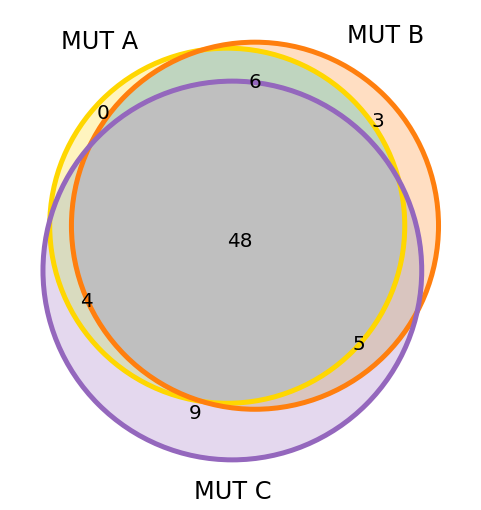

In [16]:
gold = '#FFD700'
tab_orange = '#ff7f0e'
tab_purple = '#9467bd'

# generate the Venn diagram plot
v = matplotlib_venn.venn3(venn_lists, set_labels = ('MUT A', 'MUT B', 'MUT C'))

v.get_patch_by_id('100').set_alpha(1/4)
v.get_patch_by_id('100').set_color(gold)
v.get_patch_by_id('100').set_lw(0)

v.get_patch_by_id('010').set_alpha(1/4)
v.get_patch_by_id('010').set_color(tab_orange) 
v.get_patch_by_id('010').set_lw(0)

v.get_patch_by_id('001').set_alpha(1/4) 
v.get_patch_by_id('001').set_color(tab_purple)
v.get_patch_by_id('001').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_orange)
c = a - b
v.get_patch_by_id('110').set_alpha(1/4)
v.get_patch_by_id('110').set_color(c.hex)    
v.get_patch_by_id('110').set_lw(0)

a = colorutils.Color(hex=tab_orange); b = colorutils.Color(hex=tab_purple)
c = a - b
v.get_patch_by_id('011').set_alpha(1/4)
v.get_patch_by_id('011').set_color(c.hex)    
v.get_patch_by_id('011').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_purple)
c = a - b
v.get_patch_by_id('101').set_alpha(1/4)
v.get_patch_by_id('101').set_color(c.hex)    
v.get_patch_by_id('101').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_orange); c = colorutils.Color(hex=tab_purple)
d = a - b - c
v.get_patch_by_id('111').set_alpha(1/4)
v.get_patch_by_id('111').set_color(d.hex)    
v.get_patch_by_id('111').set_lw(2)

c = matplotlib_venn.venn3_circles(subsets=venn_lists, lw=5)
c[0].set_fill(False)
c[0].set_color(gold)
c[1].set_fill(False)
c[1].set_color(tab_orange)
c[2].set_fill(False)
c[2].set_color(tab_purple)

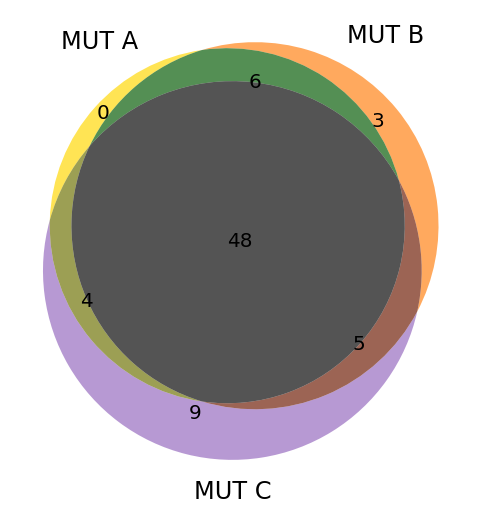

In [17]:
gold = '#FFD700'
tab_orange = '#ff7f0e'
tab_purple = '#9467bd'

# generate the Venn diagram plot
v = matplotlib_venn.venn3(venn_lists, set_labels = ('MUT A', 'MUT B', 'MUT C'))

v.get_patch_by_id('100').set_alpha(2/3)
v.get_patch_by_id('100').set_color(gold)
v.get_patch_by_id('100').set_lw(0)

v.get_patch_by_id('010').set_alpha(2/3)
v.get_patch_by_id('010').set_color(tab_orange) 
v.get_patch_by_id('010').set_lw(0)

v.get_patch_by_id('001').set_alpha(2/3) 
v.get_patch_by_id('001').set_color(tab_purple)
v.get_patch_by_id('001').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_orange)
c = a - b
v.get_patch_by_id('110').set_alpha(2/3)
v.get_patch_by_id('110').set_color(c.hex)    
v.get_patch_by_id('110').set_lw(0)

a = colorutils.Color(hex=tab_orange); b = colorutils.Color(hex=tab_purple)
c = a - b
v.get_patch_by_id('011').set_alpha(2/3)
v.get_patch_by_id('011').set_color(c.hex)    
v.get_patch_by_id('011').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_purple)
c = a - b
v.get_patch_by_id('101').set_alpha(2/3)
v.get_patch_by_id('101').set_color(c.hex)    
v.get_patch_by_id('101').set_lw(0)

a = colorutils.Color(hex=gold); b = colorutils.Color(hex=tab_orange); c = colorutils.Color(hex=tab_purple)
d = a - b - c
v.get_patch_by_id('111').set_alpha(2/3)
v.get_patch_by_id('111').set_color(d.hex)    
v.get_patch_by_id('111').set_lw(2)
v.get_patch_by_id('111').set_lw(0)

# 4. plot and print identified genes

## 4.1. print selected set of genes

In [18]:
for ensembl in list_five:
    print(ensembl)

ENSMUSG00000001751
ENSMUSG00000003617
ENSMUSG00000007872
ENSMUSG00000007891
ENSMUSG00000014444
ENSMUSG00000015766
ENSMUSG00000016496
ENSMUSG00000020044
ENSMUSG00000020190
ENSMUSG00000020380
ENSMUSG00000021281
ENSMUSG00000021696
ENSMUSG00000021806
ENSMUSG00000022148
ENSMUSG00000022243
ENSMUSG00000022816
ENSMUSG00000023009
ENSMUSG00000024462
ENSMUSG00000025371
ENSMUSG00000025511
ENSMUSG00000025854
ENSMUSG00000026857
ENSMUSG00000027004
ENSMUSG00000027533
ENSMUSG00000028194
ENSMUSG00000028713
ENSMUSG00000028776
ENSMUSG00000029510
ENSMUSG00000029861
ENSMUSG00000030084
ENSMUSG00000031398
ENSMUSG00000034220
ENSMUSG00000034341
ENSMUSG00000034771
ENSMUSG00000035273
ENSMUSG00000036698
ENSMUSG00000036853
ENSMUSG00000038034
ENSMUSG00000039105
ENSMUSG00000040548
ENSMUSG00000046727
ENSMUSG00000047793
ENSMUSG00000053080
ENSMUSG00000059602
ENSMUSG00000068220
ENSMUSG00000074480
ENSMUSG00000074968
ENSMUSG00000083257


Enrichment is the same as for DESeq2

Reactome pathways	#	#	expected	Fold Enrichment	+/-	P value
HS-GAG degradation	22	4	.04	93.01	+	3.02E-04
Heparan sulfate/heparin (HS-GAG) metabolism	54	4	.11	37.89	+	8.19E-03

In [19]:
index = 0
for ensembl in list_five:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0]
    if simple_expression.loc[ensembl, 'MUT_72h'] > simple_expression.loc[ensembl, 'MUT_0h']:
        trend = 'up'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'red'))
    else:
        trend = 'down'
        message = '\t'.join([str(index), ensembl, gene_name, trend, description])
        print(termcolor.colored(message, 'blue'))

1	ENSMUSG00000001751	Naglu	down	alpha-N-acetylglucosaminidase (Sanfilippo disease IIIB)
2	ENSMUSG00000003617	Cp	up	ceruloplasmin
3	ENSMUSG00000007872	Id3	up	inhibitor of DNA binding 3
4	ENSMUSG00000007891	Ctsd	down	cathepsin D
5	ENSMUSG00000014444	Piezo1	down	piezo-type mechanosensitive ion channel component 1
6	ENSMUSG00000015766	Eps8	down	epidermal growth factor receptor pathway substrate 8
7	ENSMUSG00000016496	Cd274	up	CD274 antigen
8	ENSMUSG00000020044	Timp3	up	tissue inhibitor of metalloproteinase 3
9	ENSMUSG00000020190	Mknk2	down	MAP kinase-interacting serine/threonine kinase 2
10	ENSMUSG00000020380	Rad50	down	RAD50 double strand break repair protein
11	ENSMUSG00000021281	Tnfaip2	down	tumor necrosis factor, alpha-induced protein 2
12	ENSMUSG00000021696	Elovl7	down	ELOVL family member 7, elongation of long chain fatty acids (yeast)
13	ENSMUSG00000021806	Nid2	up	nidogen 2
14	ENSMUSG00000022148	Fyb	up	FYN binding protein
15	ENSMUSG00000022243	Slc45a2	down	solute carrier family 45, m

In [20]:
# comparison with DESeq2 relax
list_deseq2 = ['ENSMUSG00000001751', 'ENSMUSG00000003617', 'ENSMUSG00000006235', 'ENSMUSG00000009687', 'ENSMUSG00000014444', 'ENSMUSG00000015766', 'ENSMUSG00000016496', 'ENSMUSG00000020190', 'ENSMUSG00000021696', 'ENSMUSG00000022243', 'ENSMUSG00000023009', 'ENSMUSG00000025511', 'ENSMUSG00000026857', 'ENSMUSG00000028194', 'ENSMUSG00000028713', 'ENSMUSG00000029510', 'ENSMUSG00000029861', 'ENSMUSG00000030084', 'ENSMUSG00000030796', 'ENSMUSG00000032564', 'ENSMUSG00000035273', 'ENSMUSG00000036698', 'ENSMUSG00000036853', 'ENSMUSG00000037049', 'ENSMUSG00000046727', 'ENSMUSG00000047793', 'ENSMUSG00000059013', 'ENSMUSG00000068220', 'ENSMUSG00000072941', 'ENSMUSG00000074892', 'ENSMUSG00000083257', 'ENSMUSG00000107874']

In [21]:
print('sleuth-specific DEGs:')
index = 0
for ensembl in list_five:
    if ensembl not in list_deseq2:
        index = index + 1
        gene_name = annotation.loc[ensembl]['ext_gene']
        description = annotation.loc[ensembl]['description'].split(' [')[0] 
        message = '\t'.join([str(index), ensembl, gene_name, description])
        print(message)

print()

print('DESeq2-specific DEGs:')
index = 0
for ensembl in list_deseq2:
    if ensembl not in list_five:
        index = index + 1
        gene_name = annotation.loc[ensembl]['ext_gene']
        description = annotation.loc[ensembl]['description'].split(' [')[0] 
        message = '\t'.join([str(index), ensembl, gene_name, description])
        print(message)
        
print()

print('Common in both')
common = list(set(list_five) & set(list_deseq2))
index = 0
for ensembl in common:
    index = index + 1
    gene_name = annotation.loc[ensembl]['ext_gene']
    description = annotation.loc[ensembl]['description'].split(' [')[0] 
    message = '\t'.join([str(index), ensembl, gene_name, description])
    print(message)

sleuth-specific DEGs:
1	ENSMUSG00000007872	Id3	inhibitor of DNA binding 3
2	ENSMUSG00000007891	Ctsd	cathepsin D
3	ENSMUSG00000020044	Timp3	tissue inhibitor of metalloproteinase 3
4	ENSMUSG00000020380	Rad50	RAD50 double strand break repair protein
5	ENSMUSG00000021281	Tnfaip2	tumor necrosis factor, alpha-induced protein 2
6	ENSMUSG00000021806	Nid2	nidogen 2
7	ENSMUSG00000022148	Fyb	FYN binding protein
8	ENSMUSG00000022816	Fstl1	follistatin-like 1
9	ENSMUSG00000024462	Gabbr1	gamma-aminobutyric acid (GABA) B receptor, 1
10	ENSMUSG00000025371	Chmp6	charged multivesicular body protein 6
11	ENSMUSG00000025854	Fam20c	FAM20C, golgi associated secretory pathway kinase
12	ENSMUSG00000027004	Frzb	frizzled-related protein
13	ENSMUSG00000027533	Fabp5	fatty acid binding protein 5, epidermal
14	ENSMUSG00000028776	Tinagl1	tubulointerstitial nephritis antigen-like 1
15	ENSMUSG00000031398	Plxna3	plexin A3
16	ENSMUSG00000034220	Gpc1	glypican 1
17	ENSMUSG00000034341	Wbp2	WW domain binding protein 2
18	ENS

## 4.2. generate trajectory plots

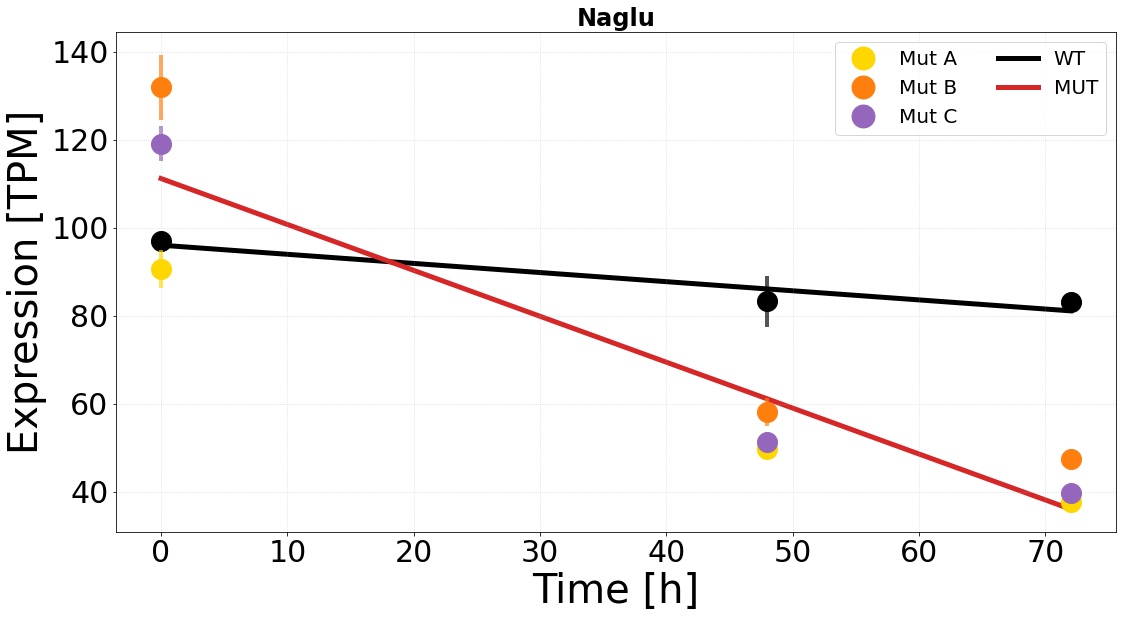

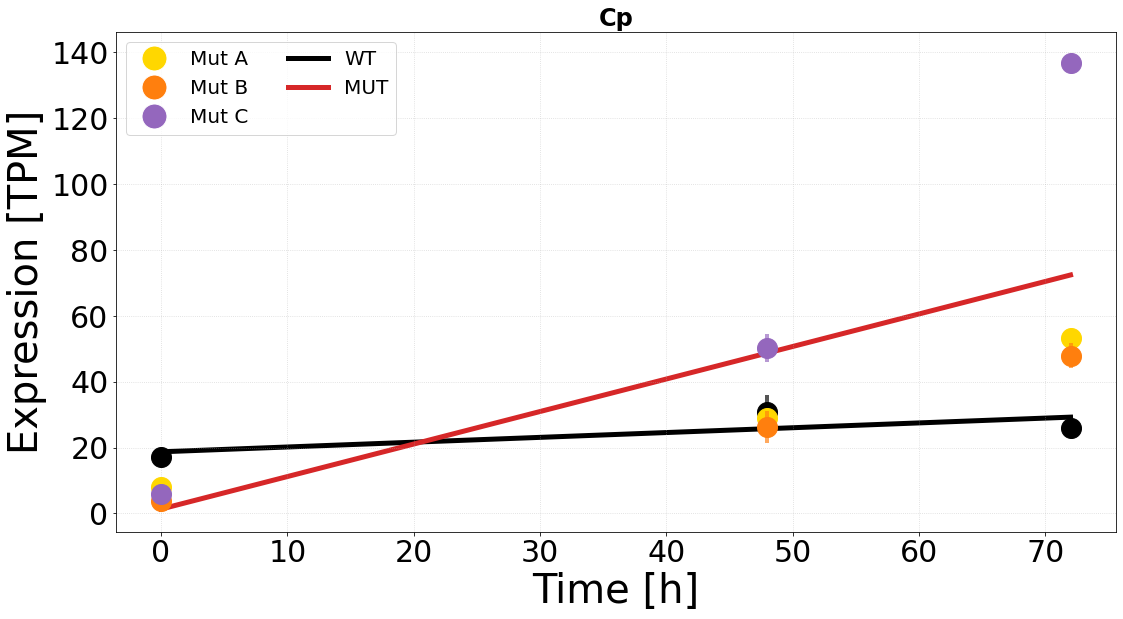

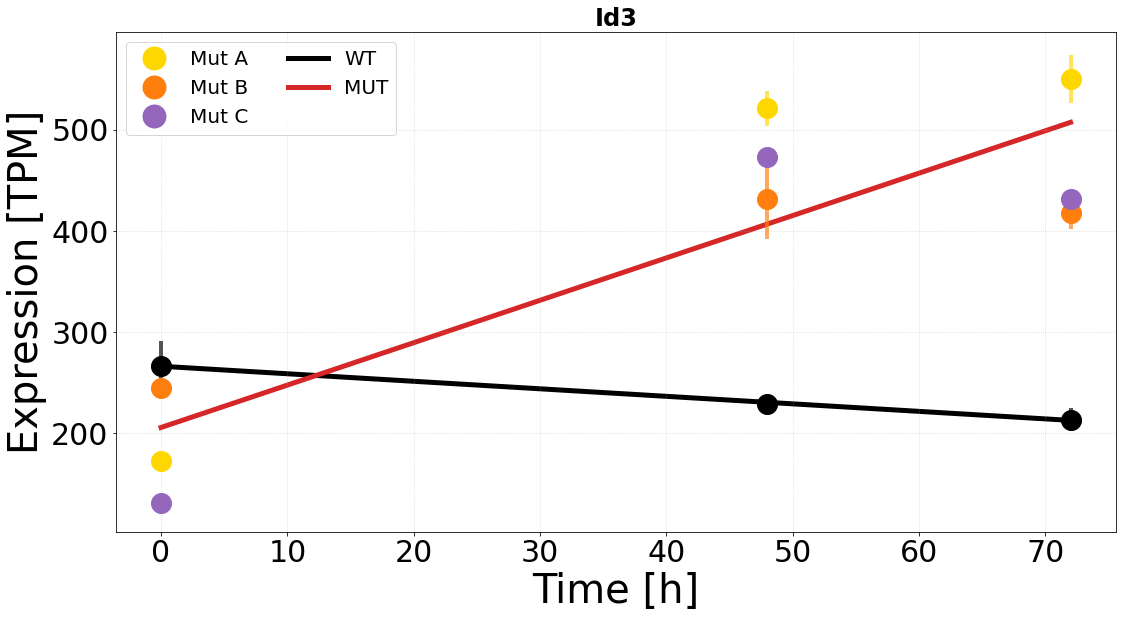

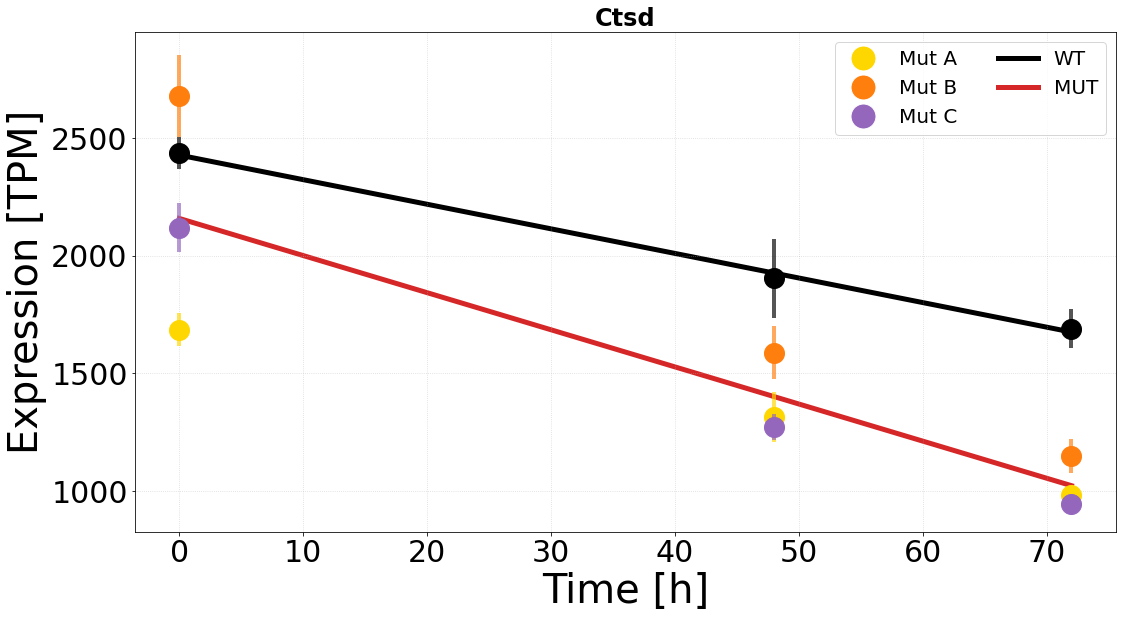

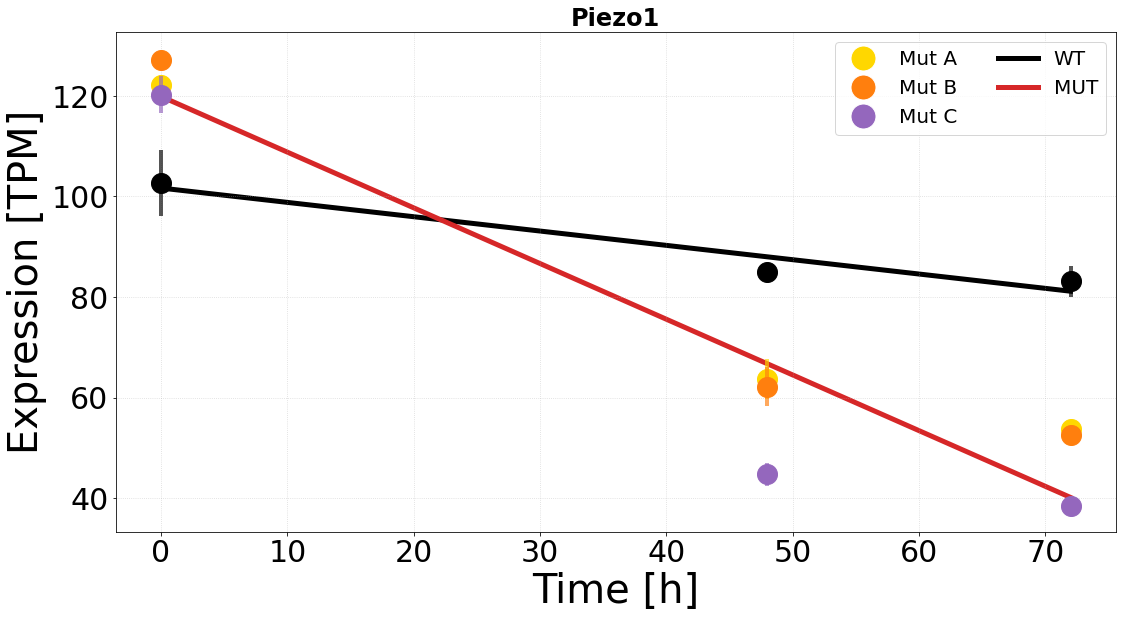

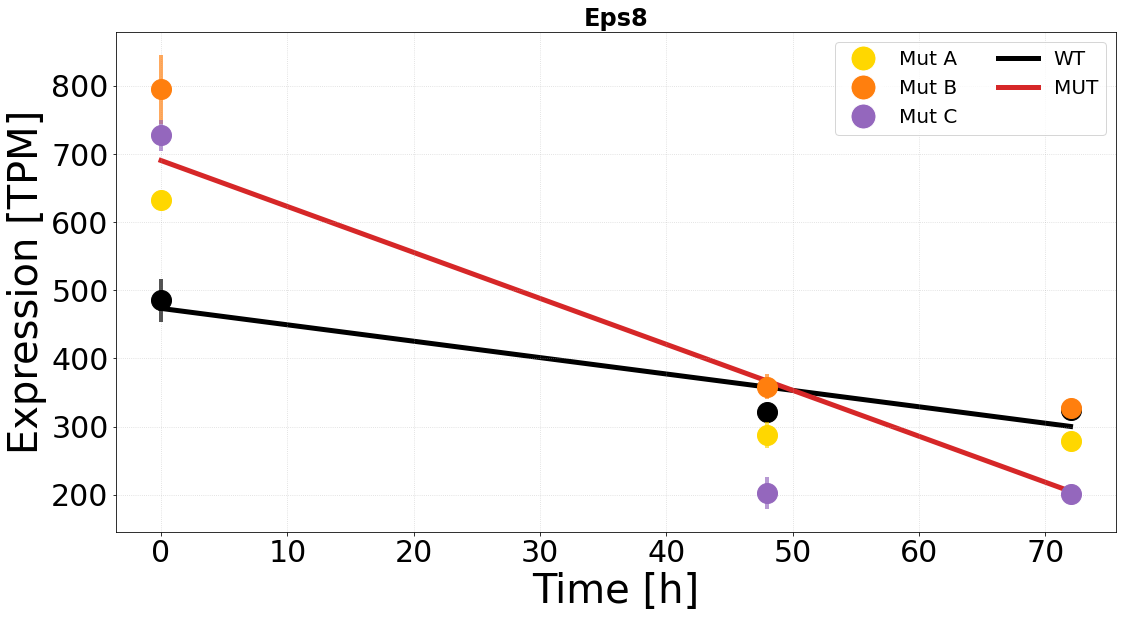

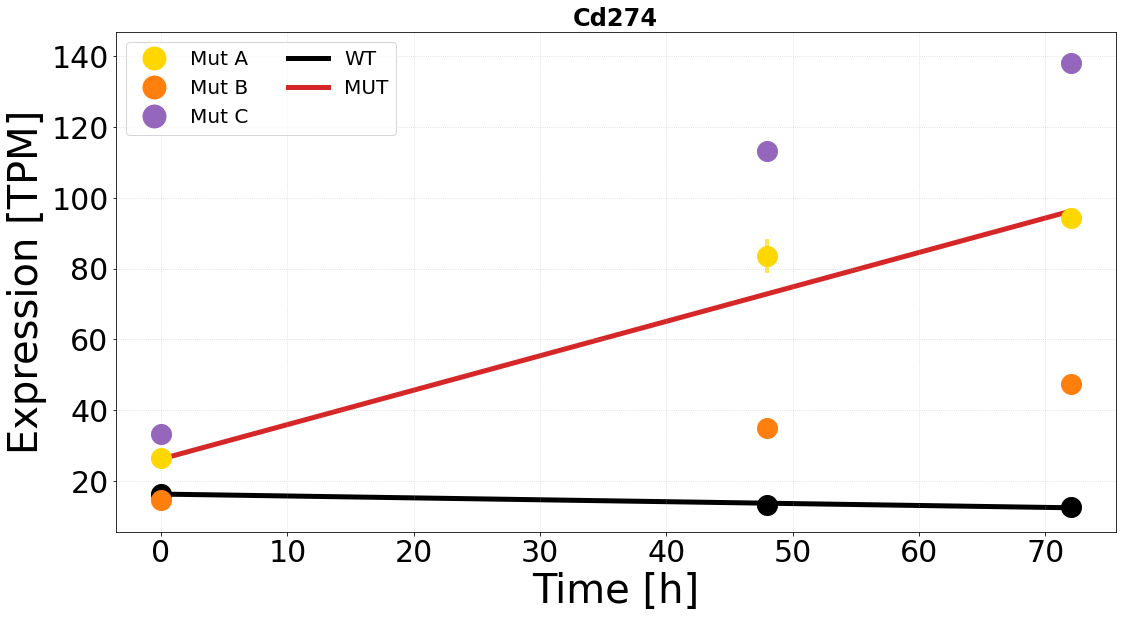

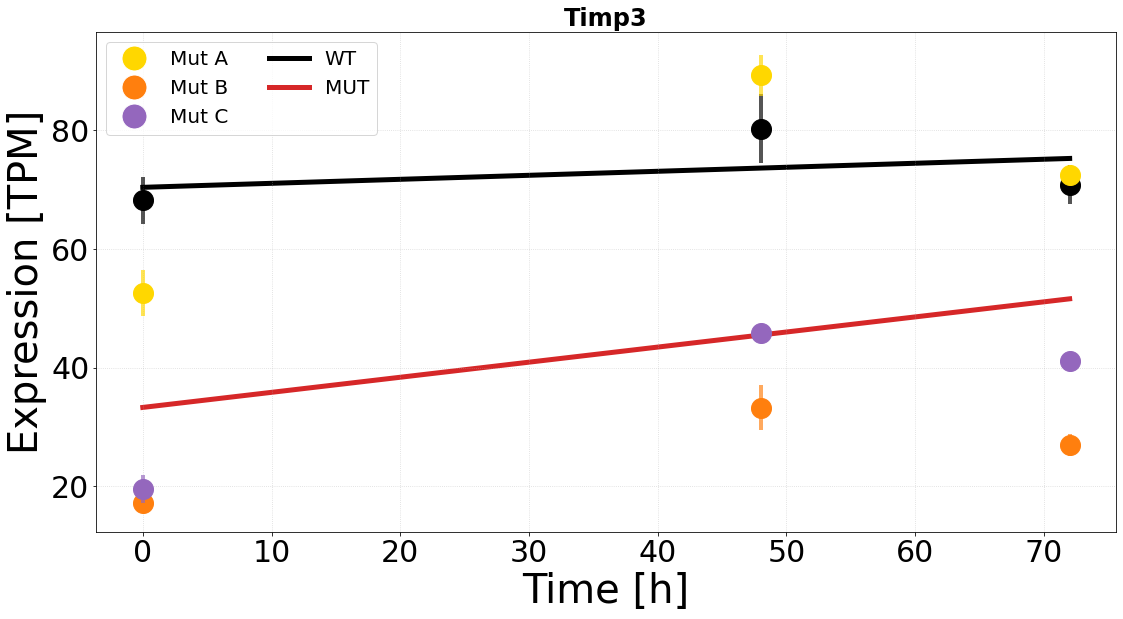

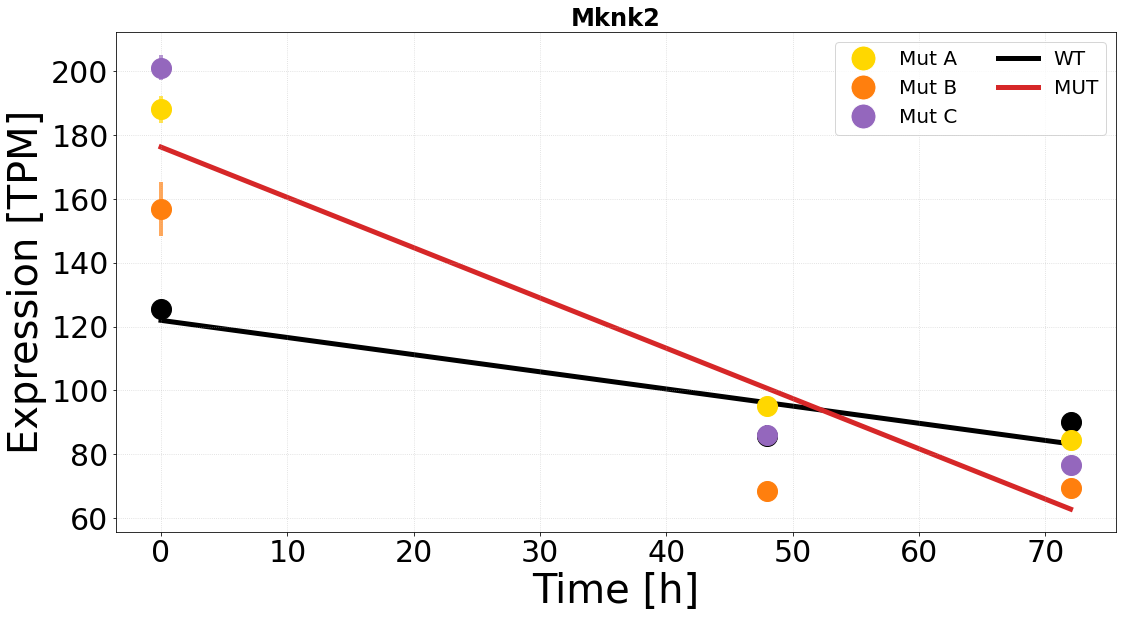

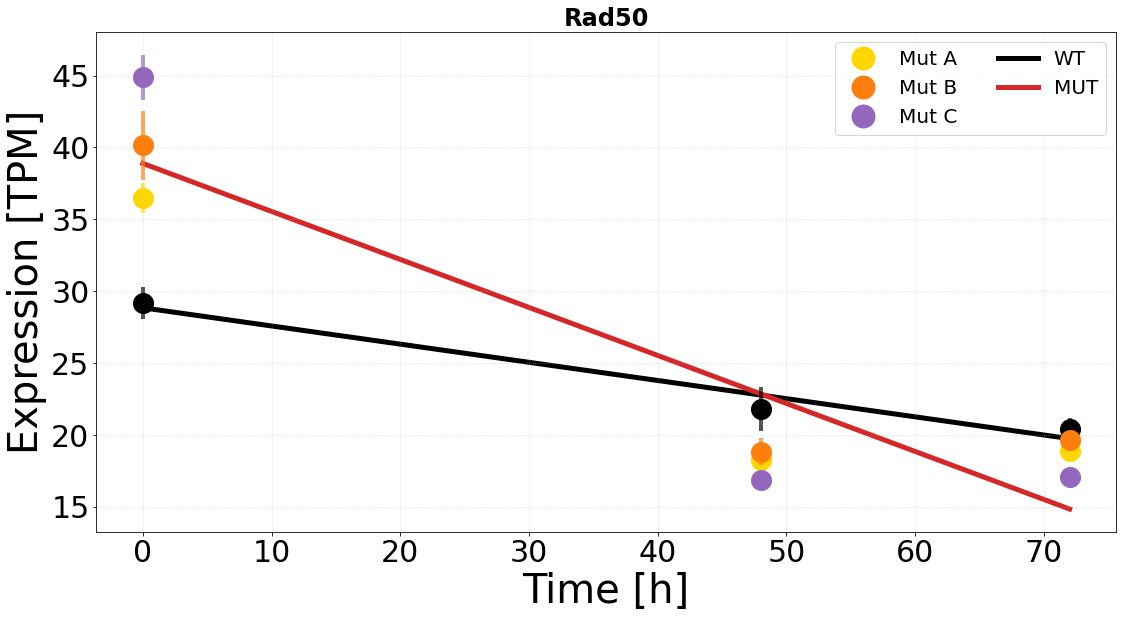

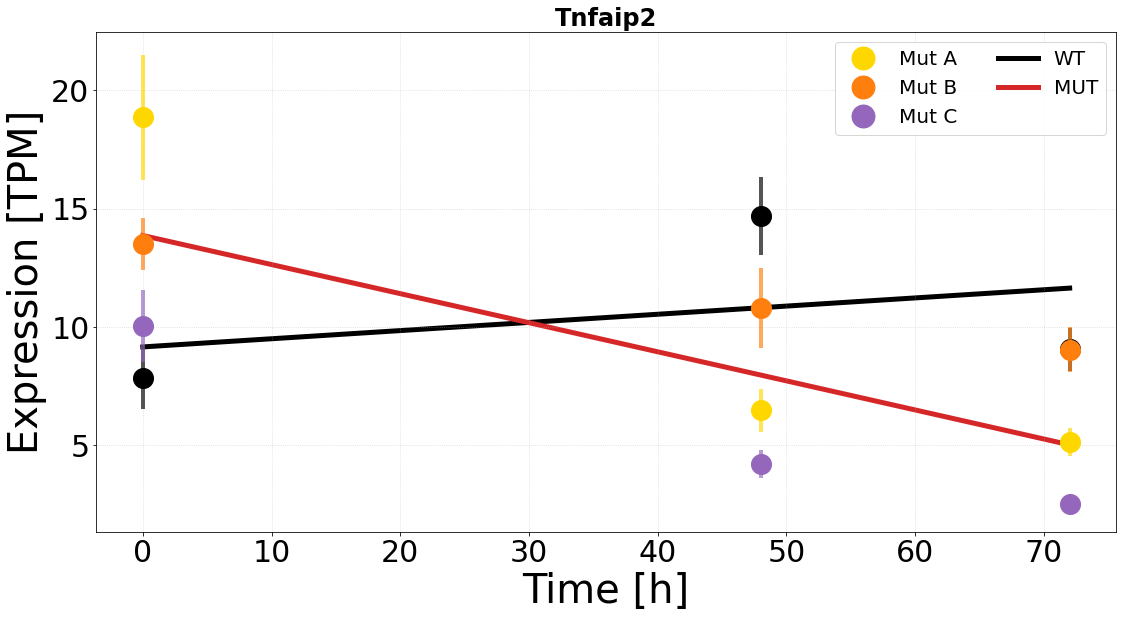

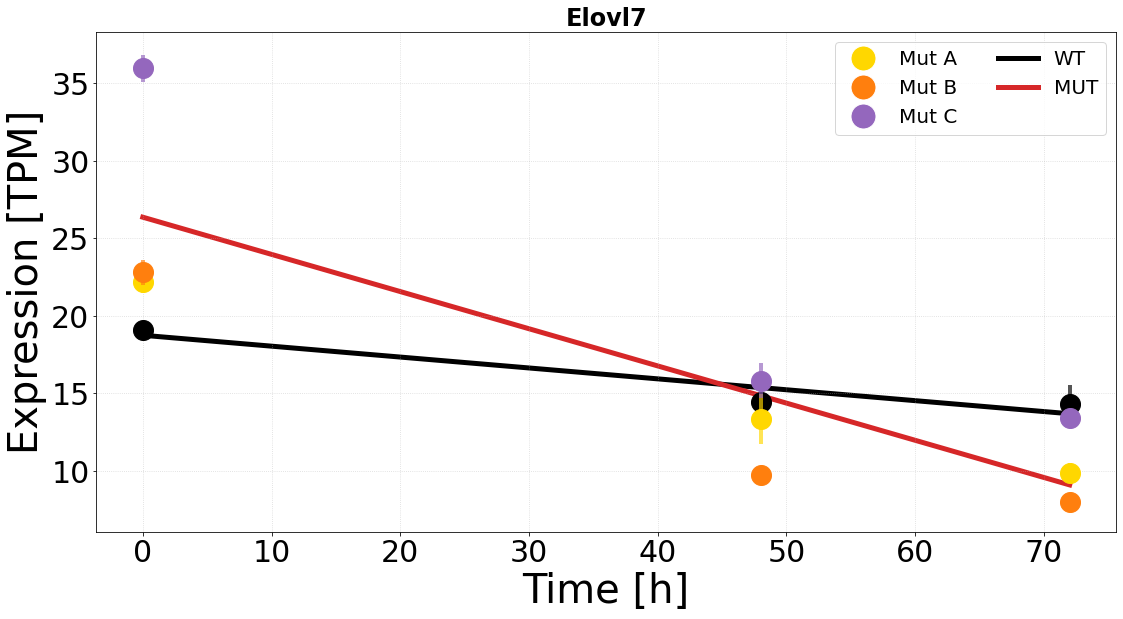

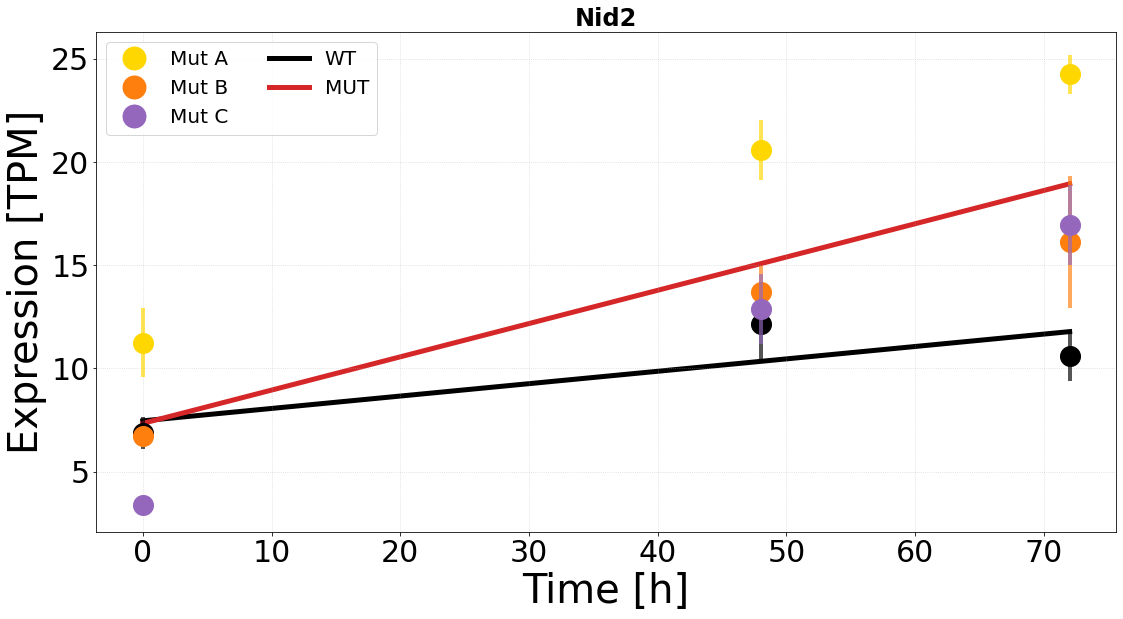

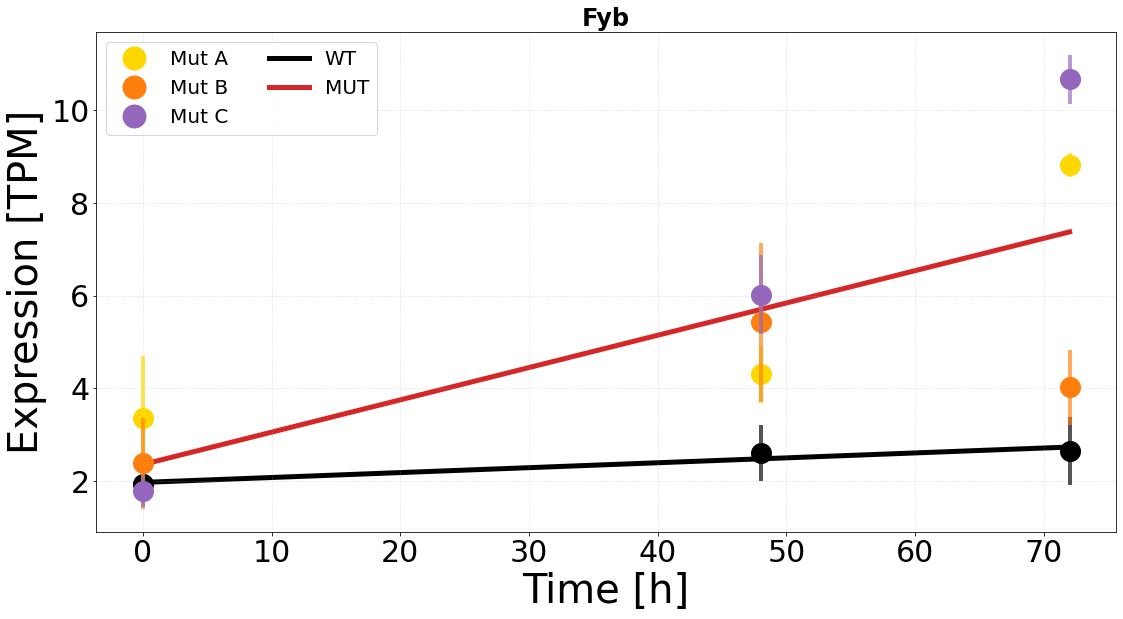

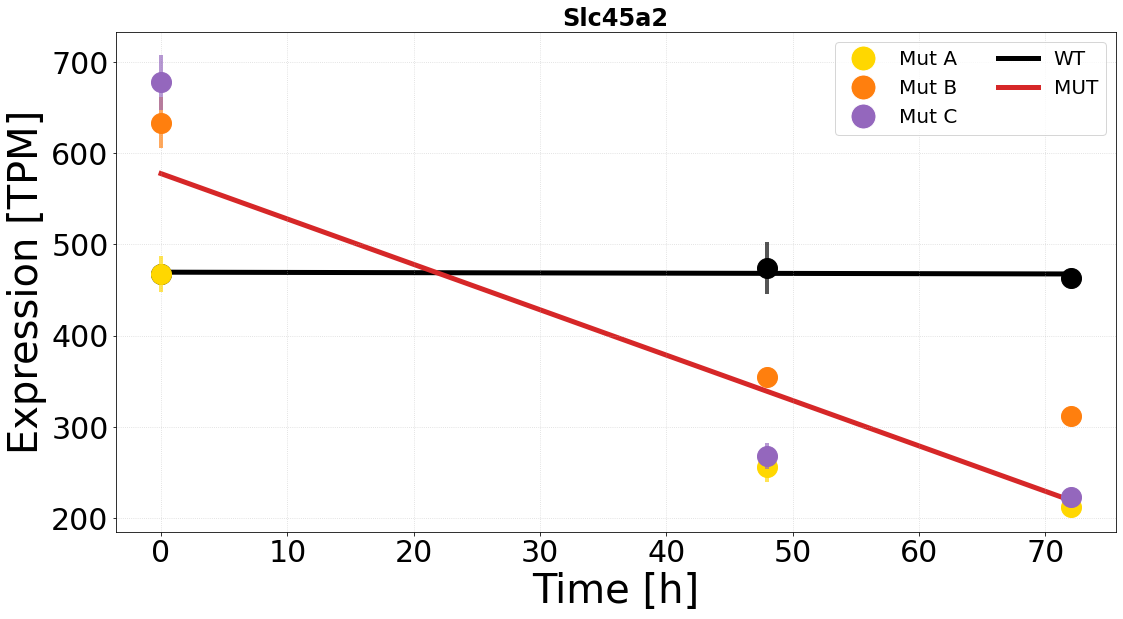

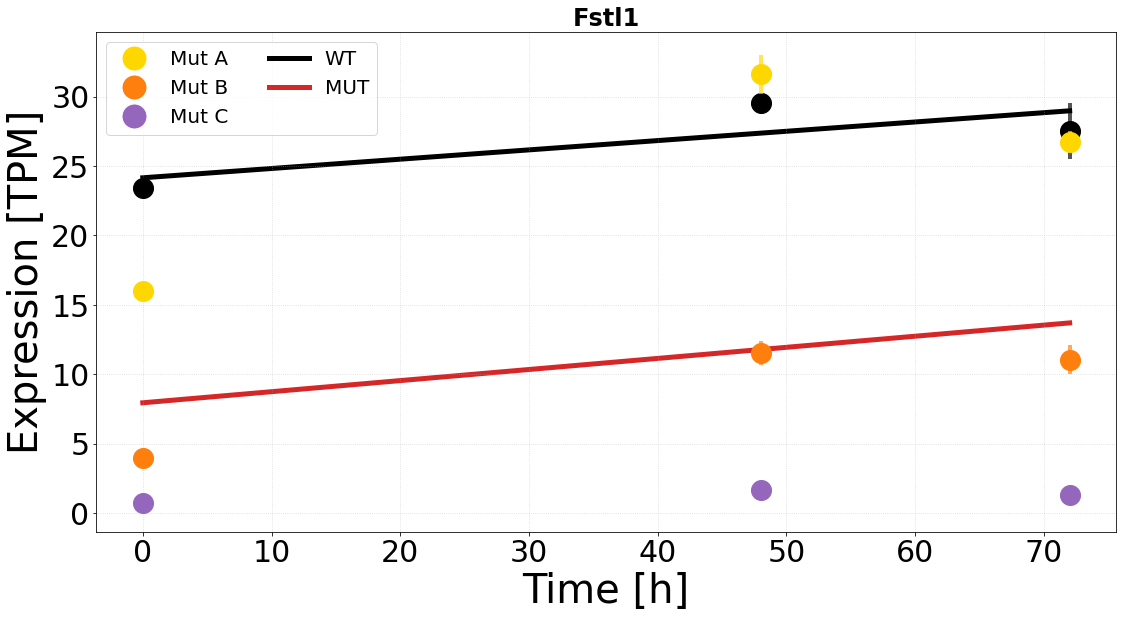

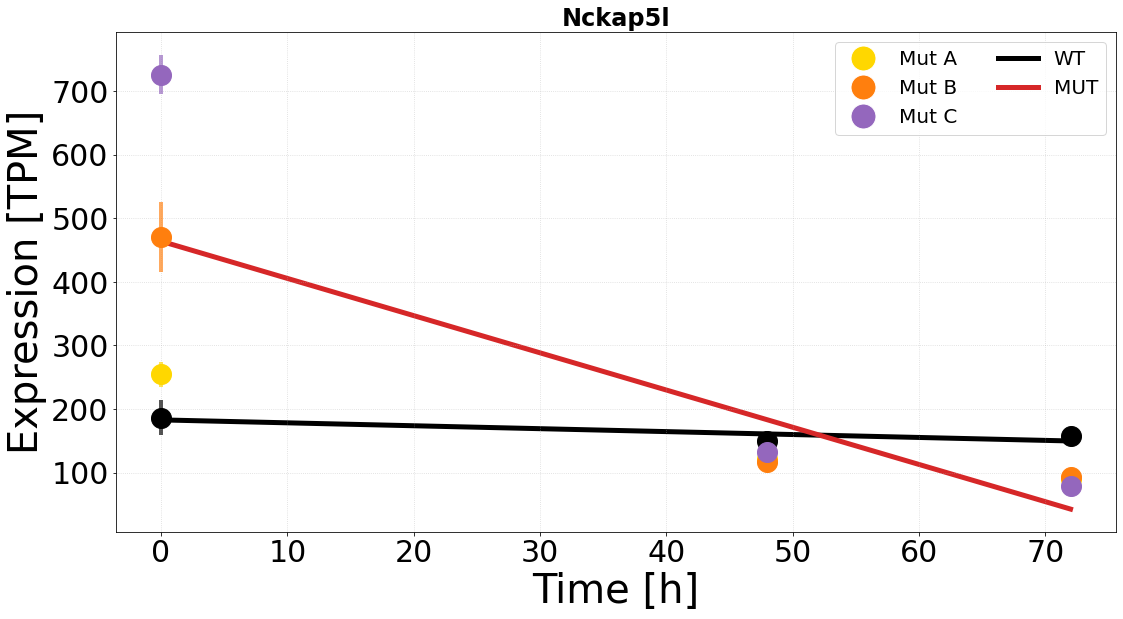

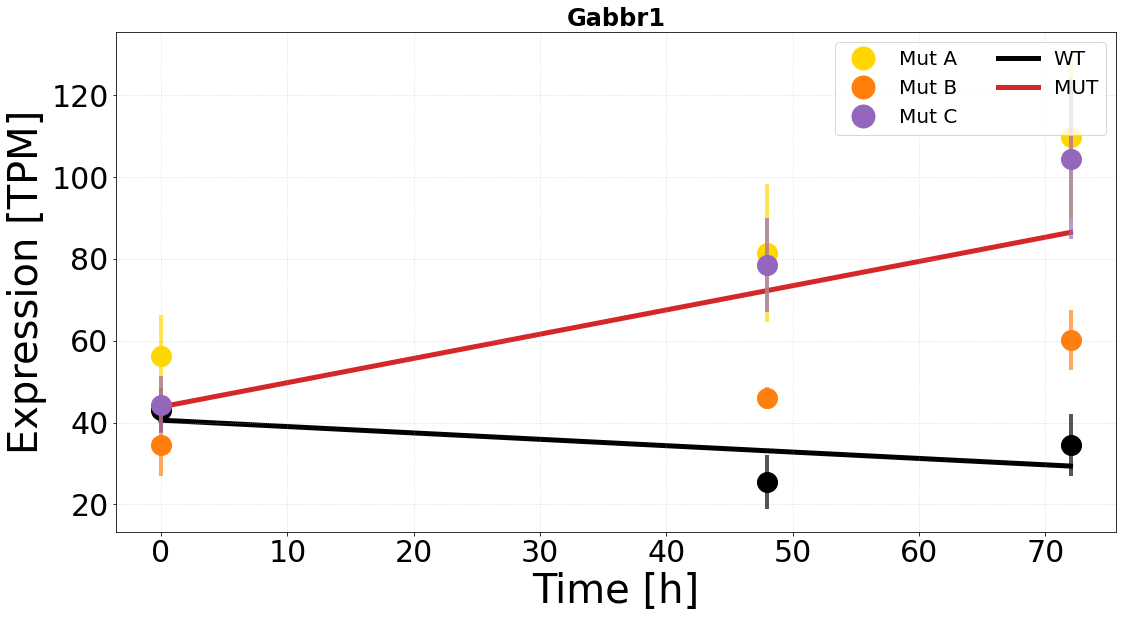

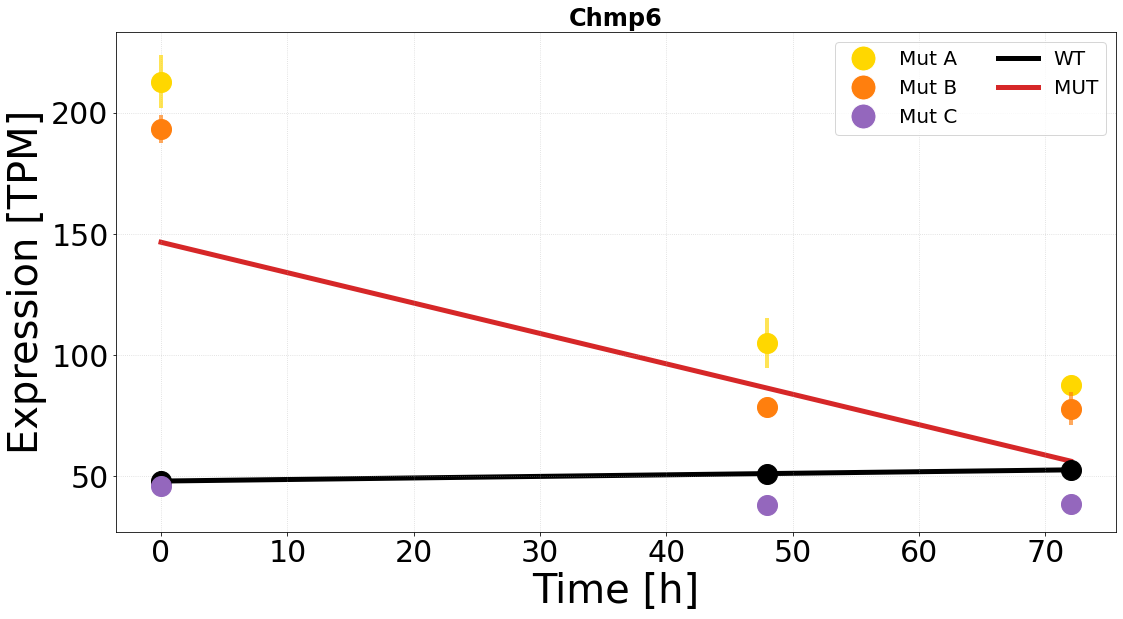

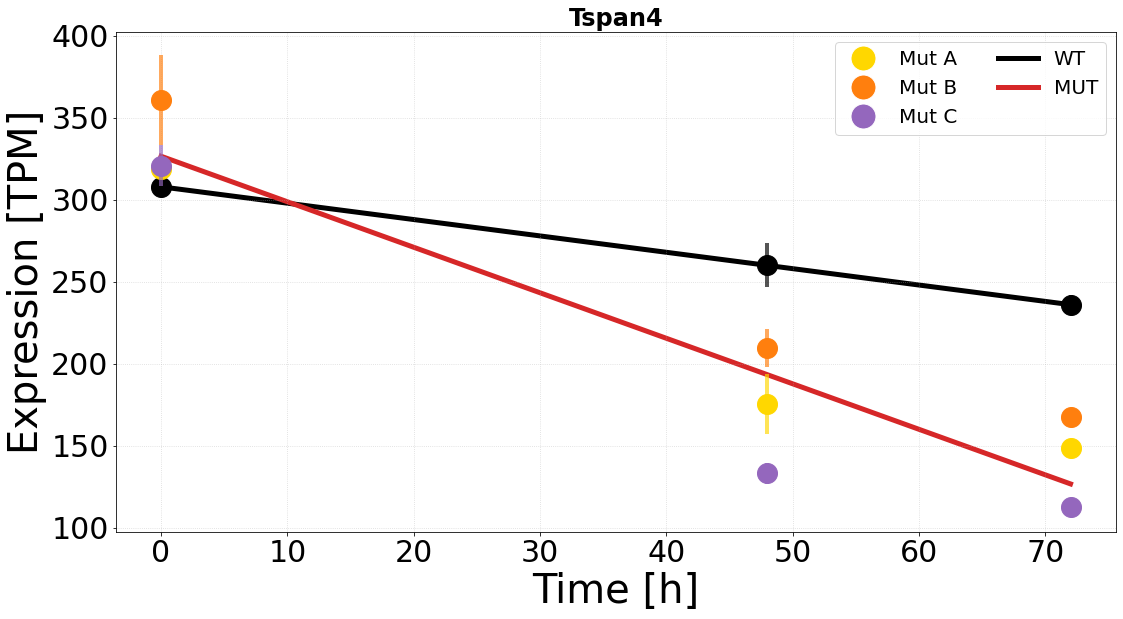

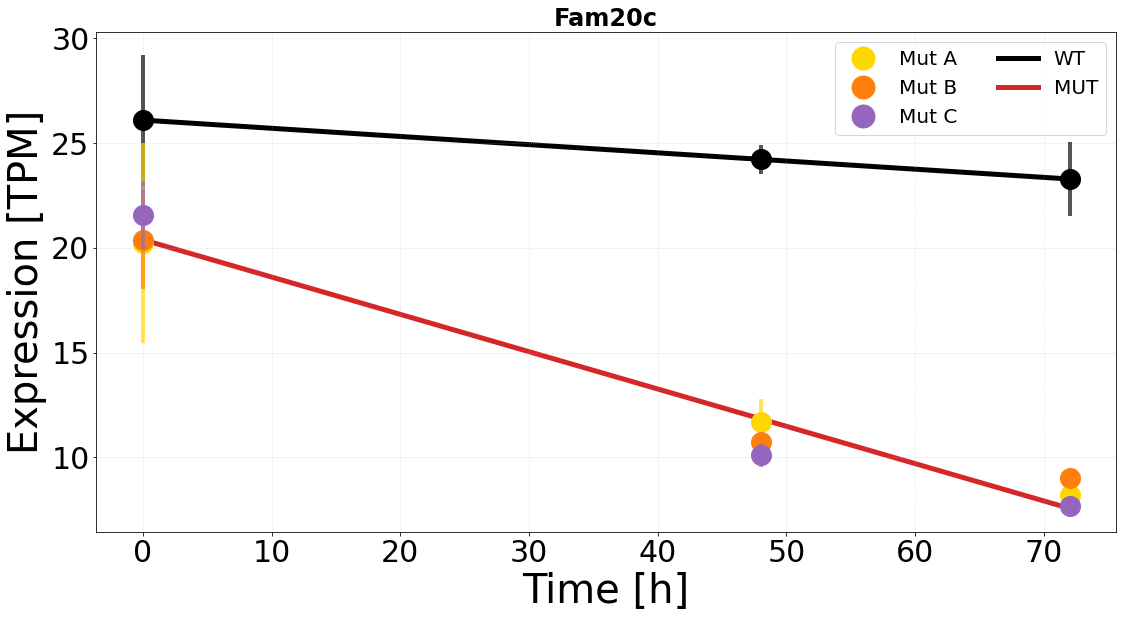

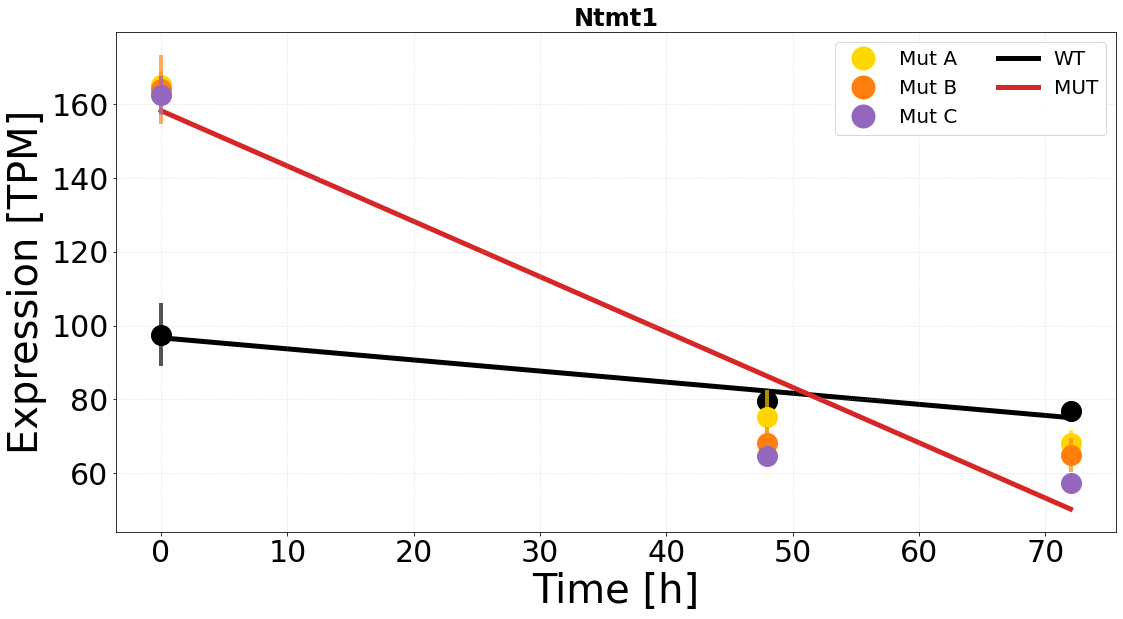

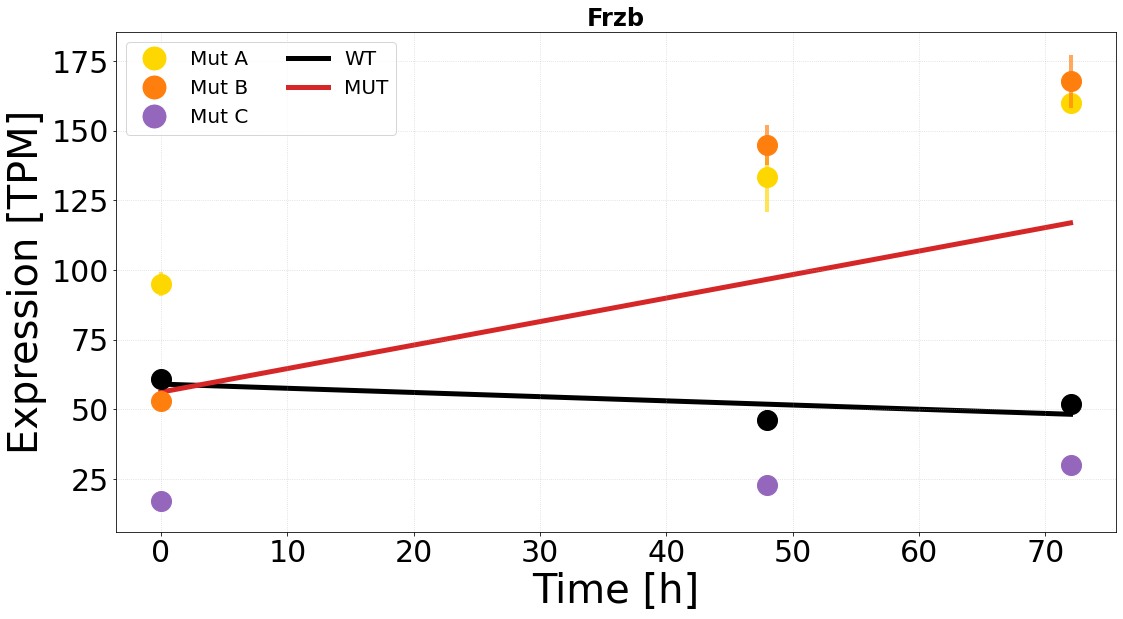

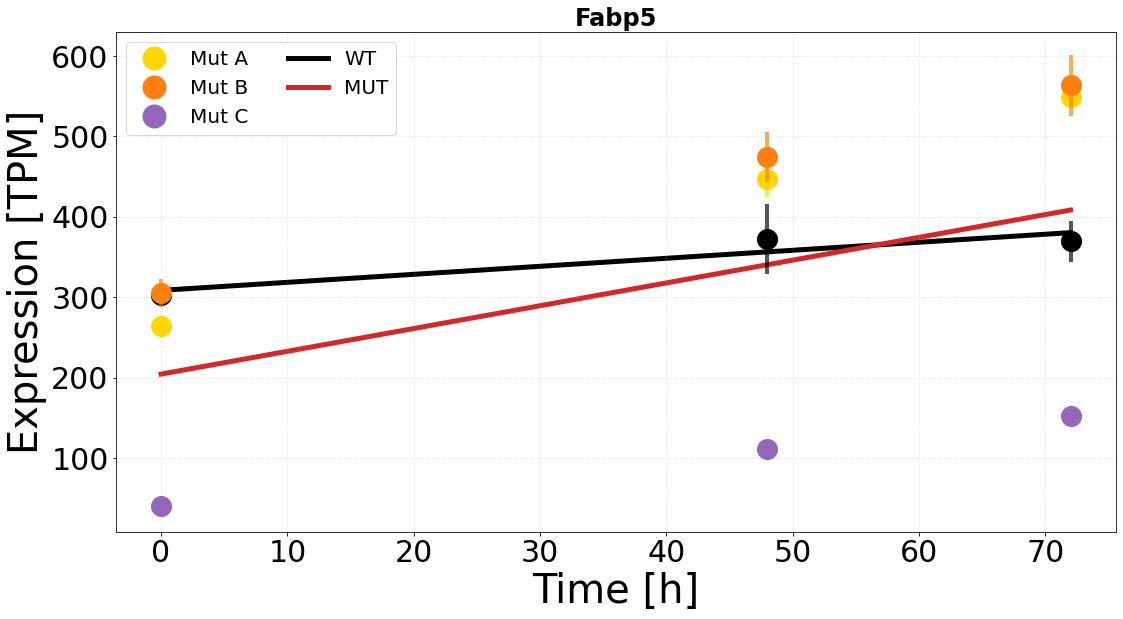

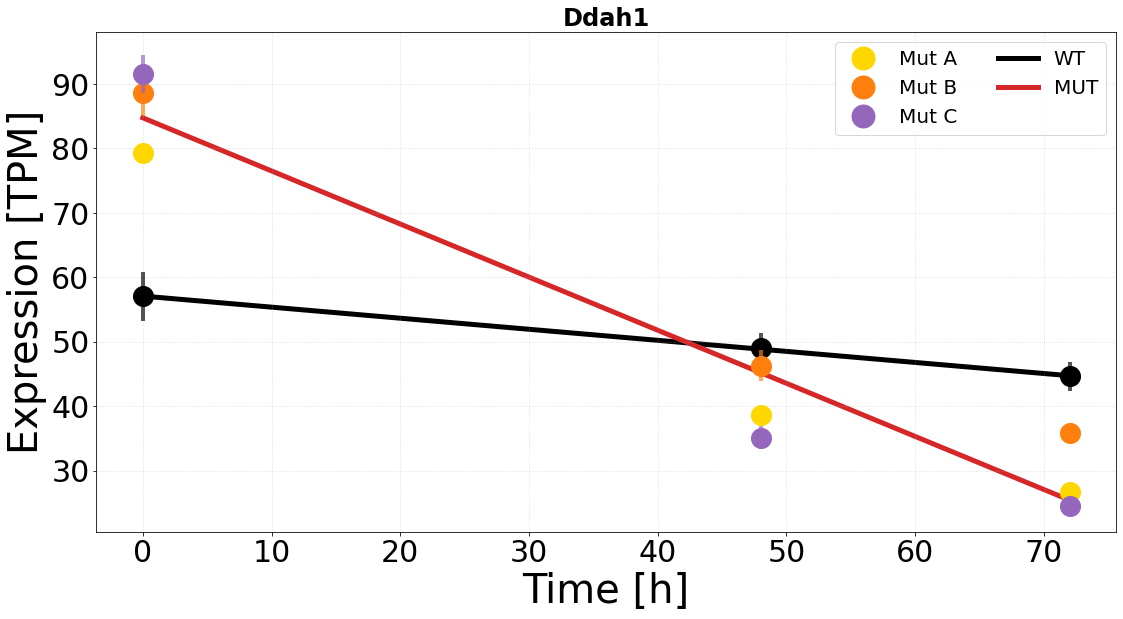

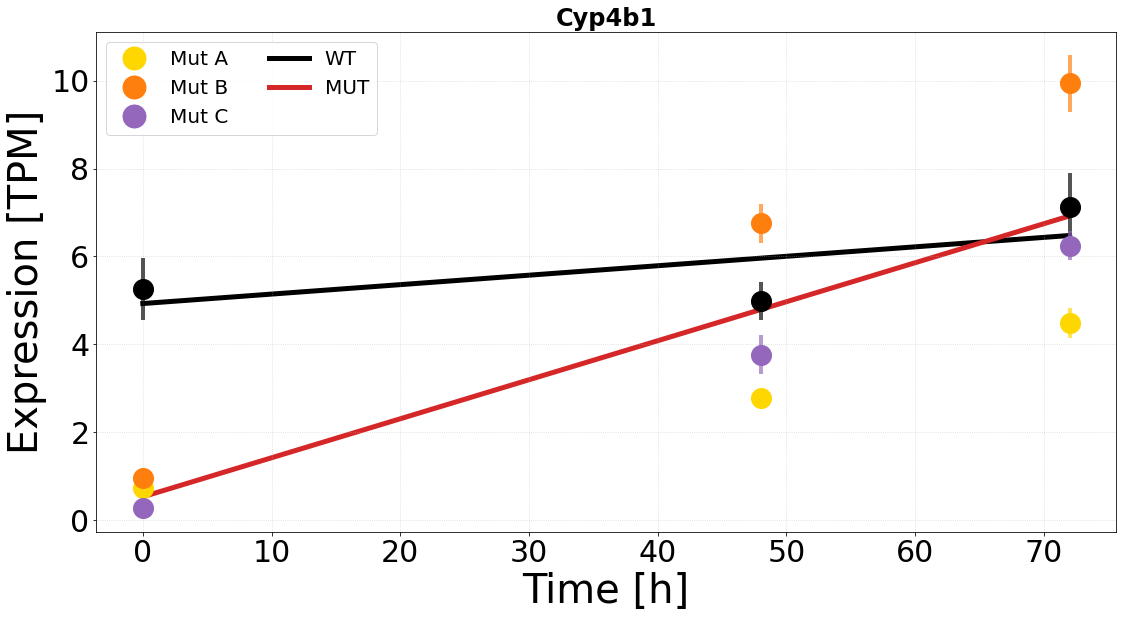

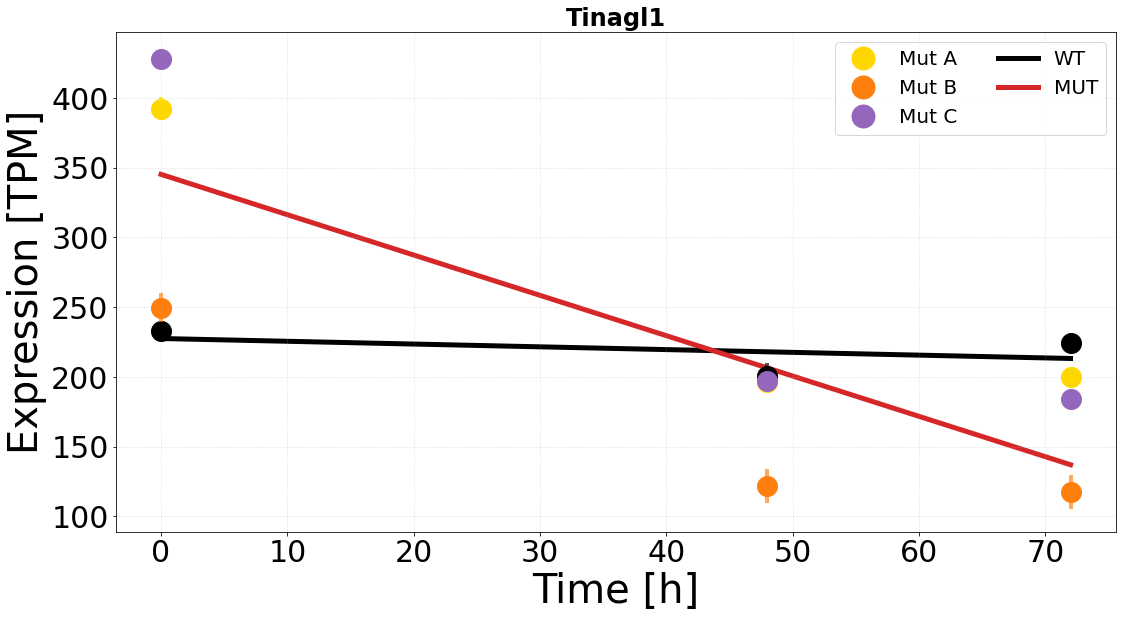

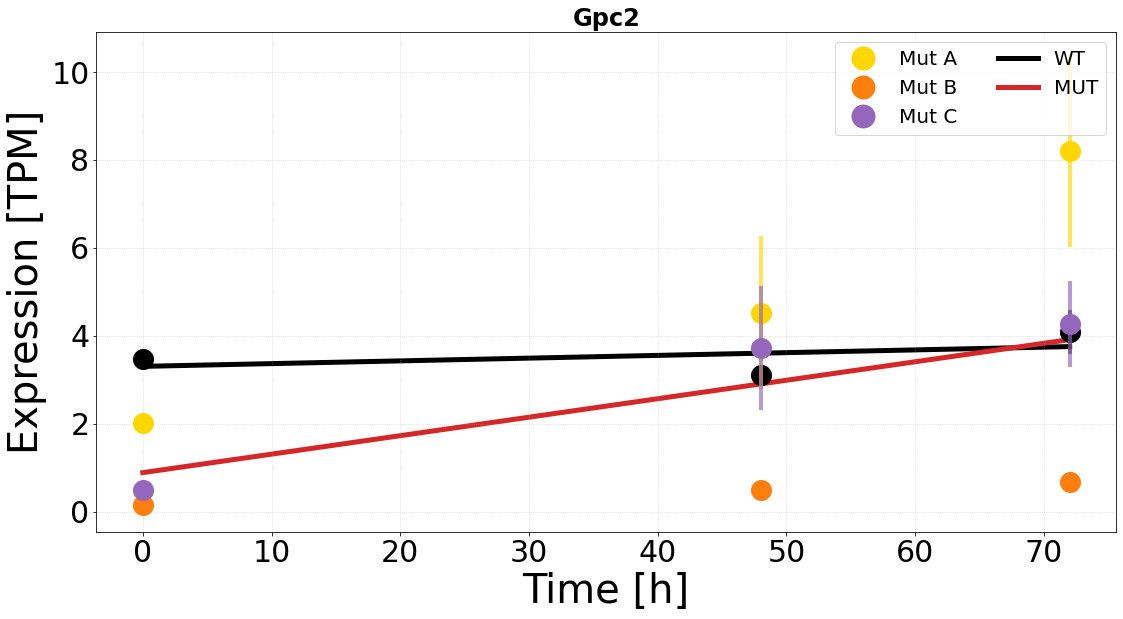

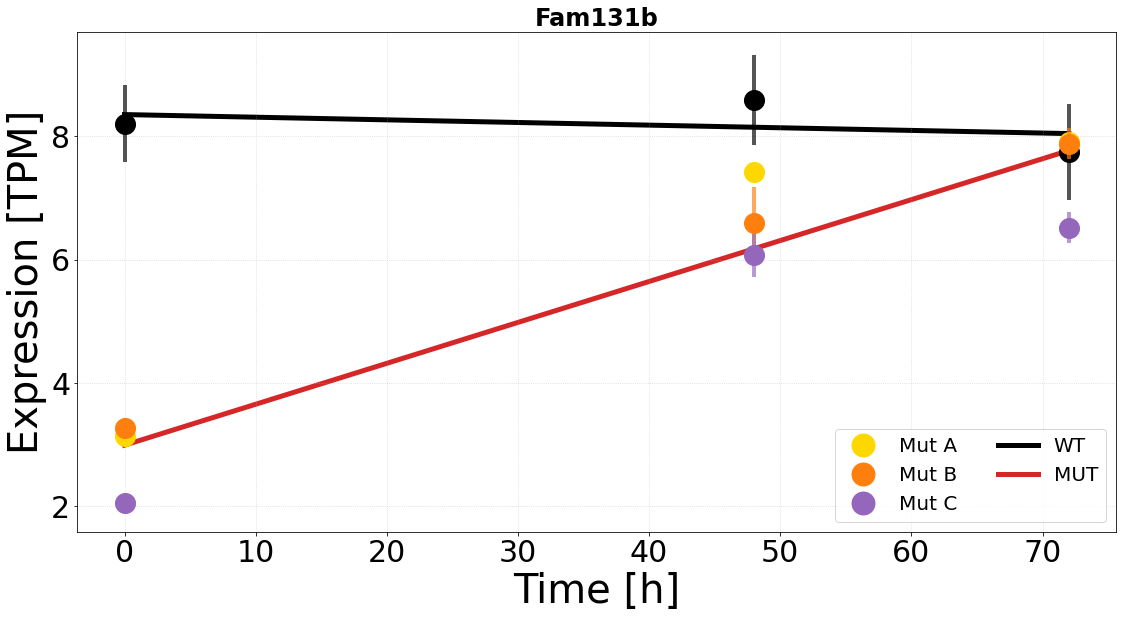

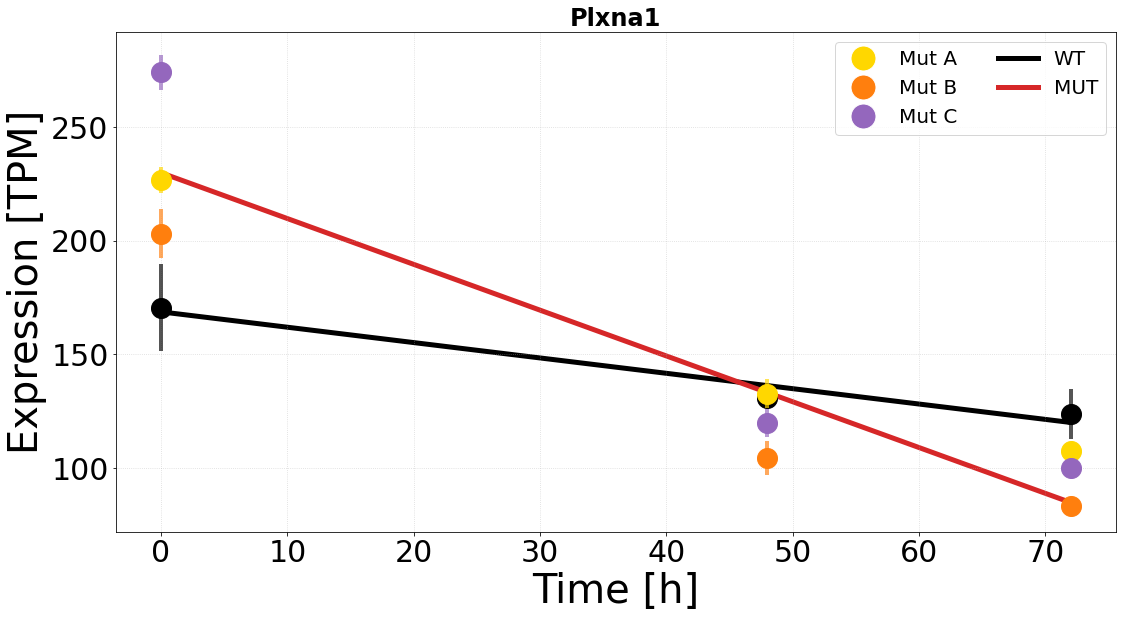

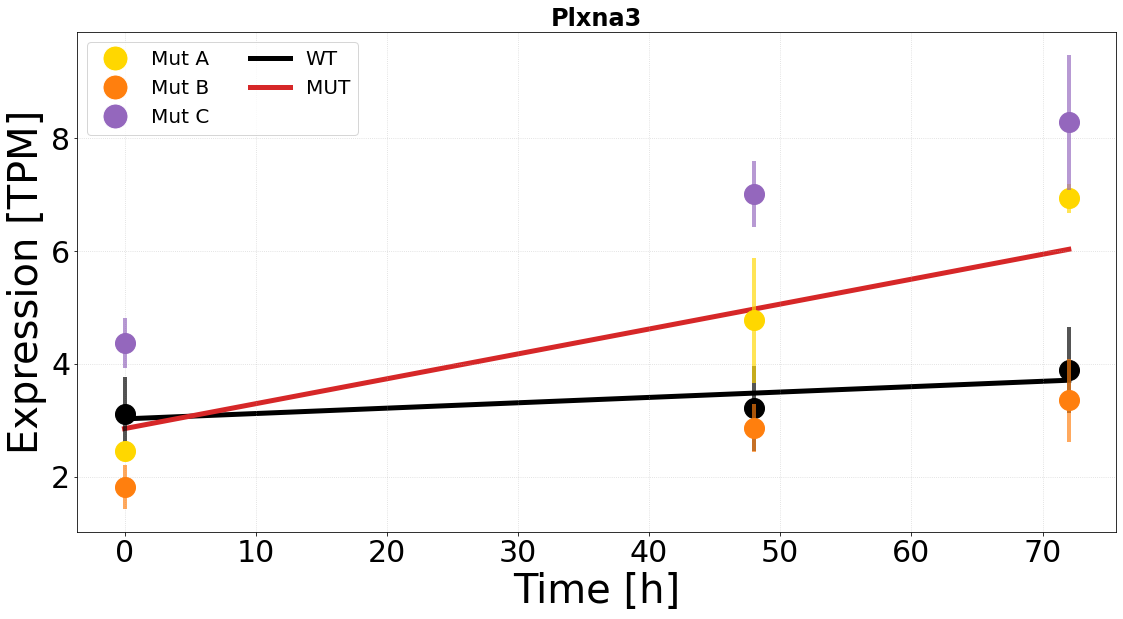

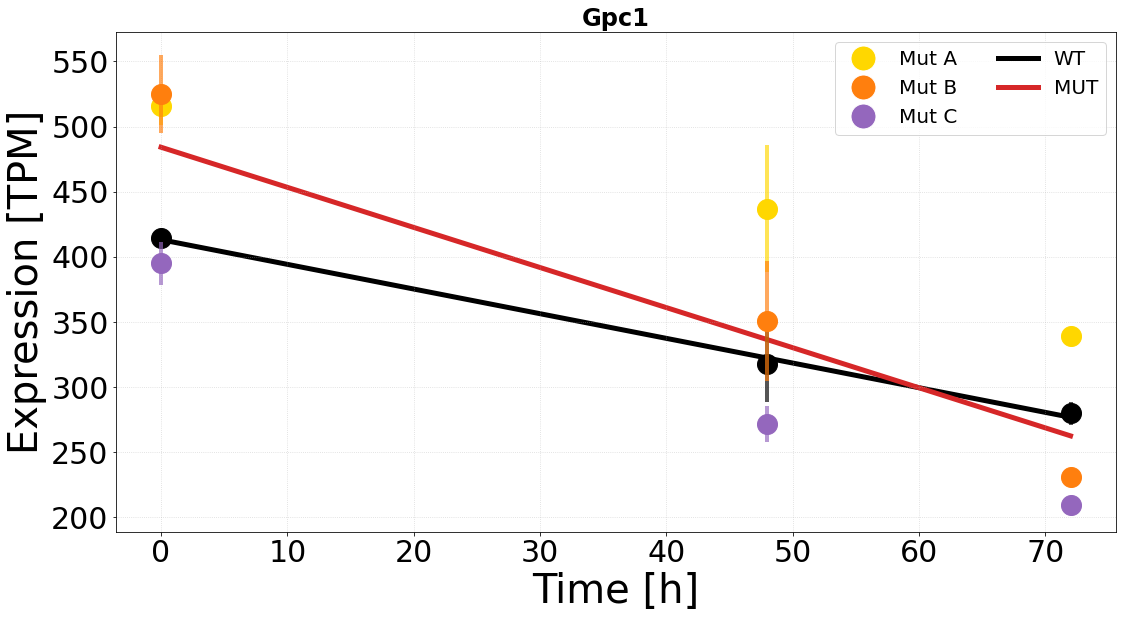

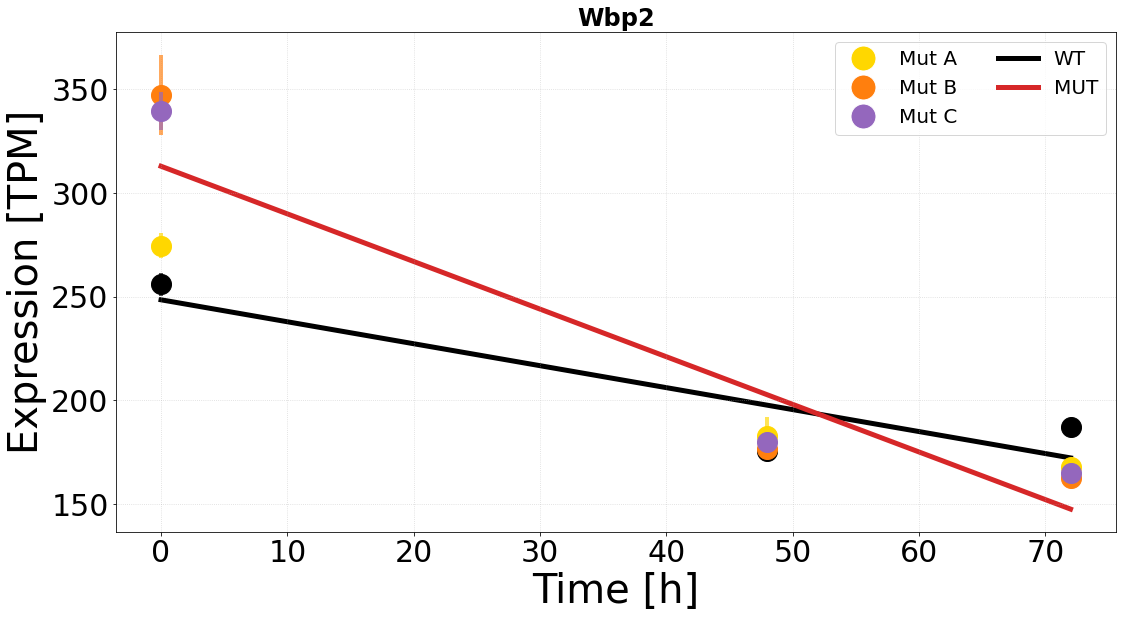

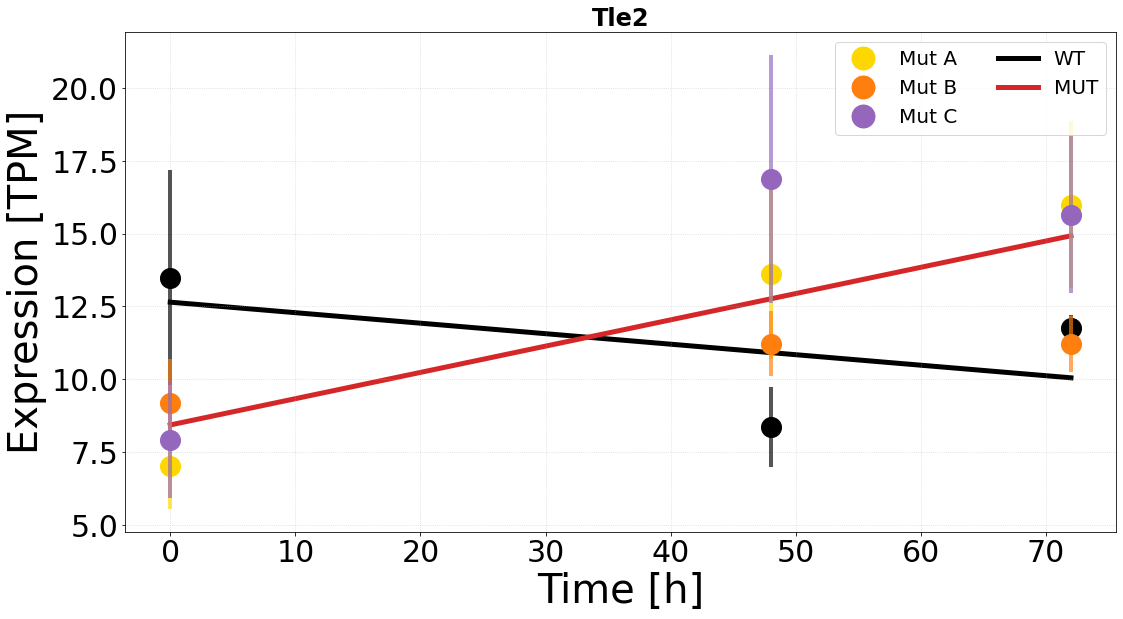

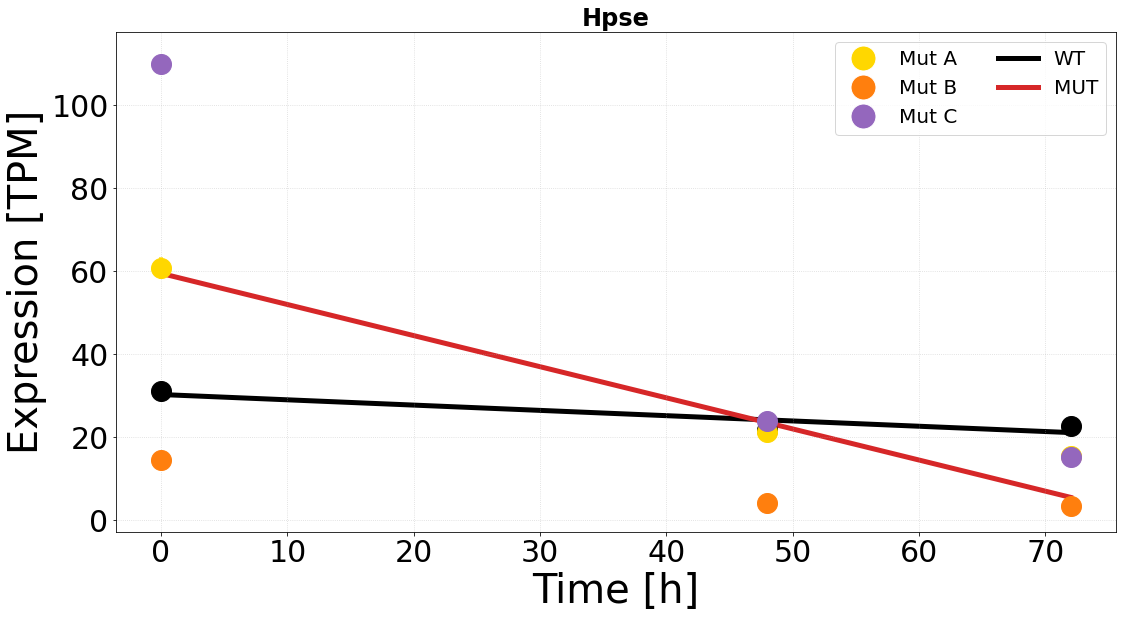

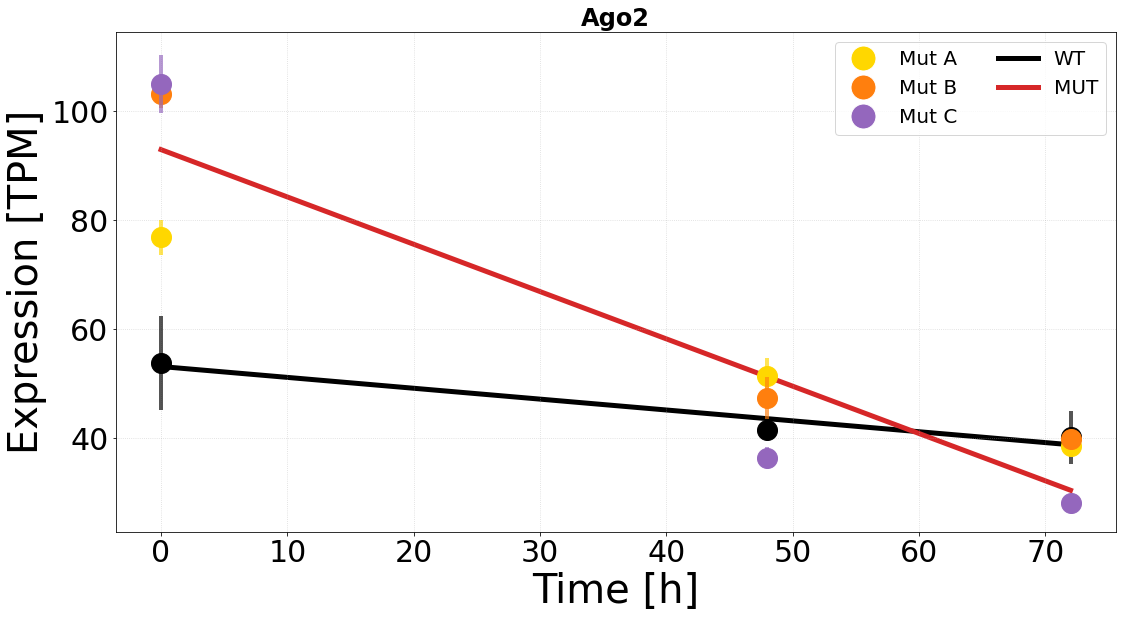

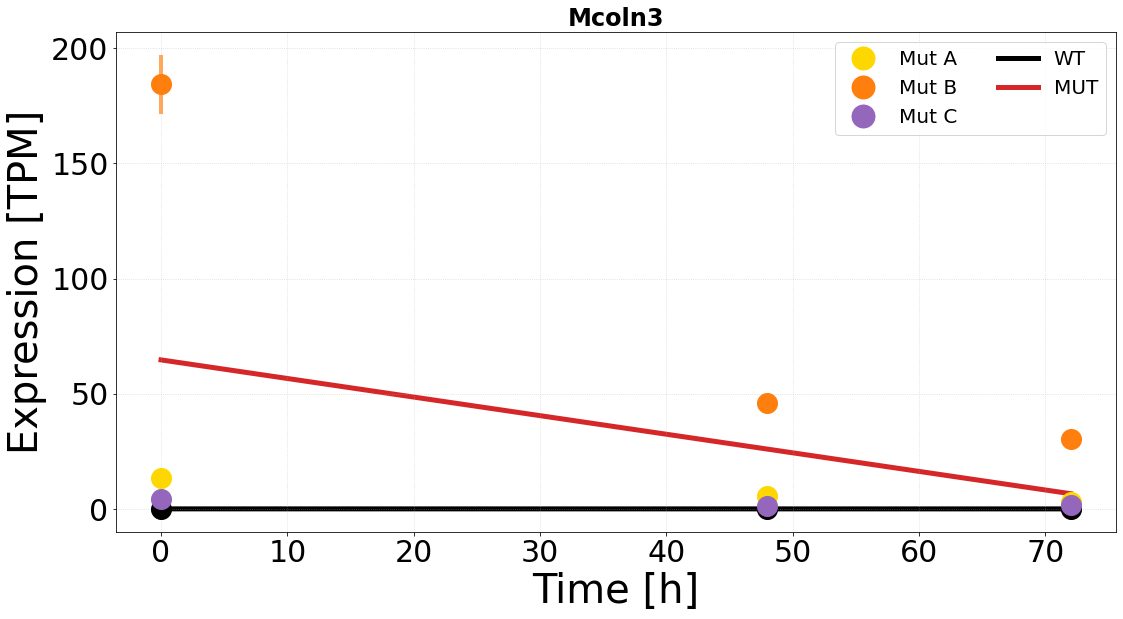

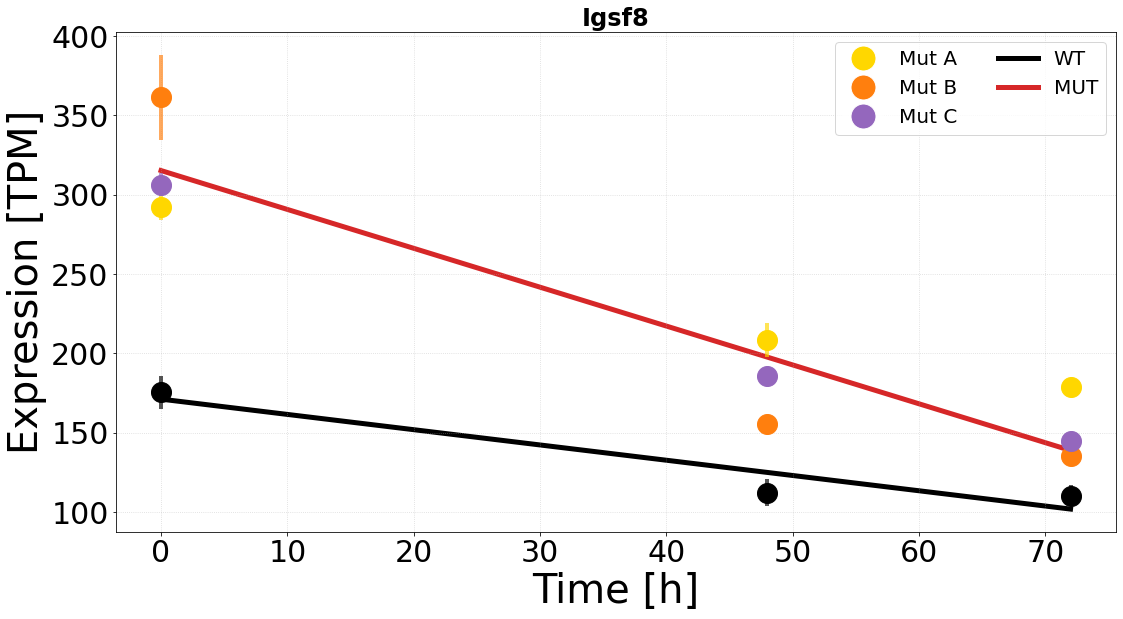

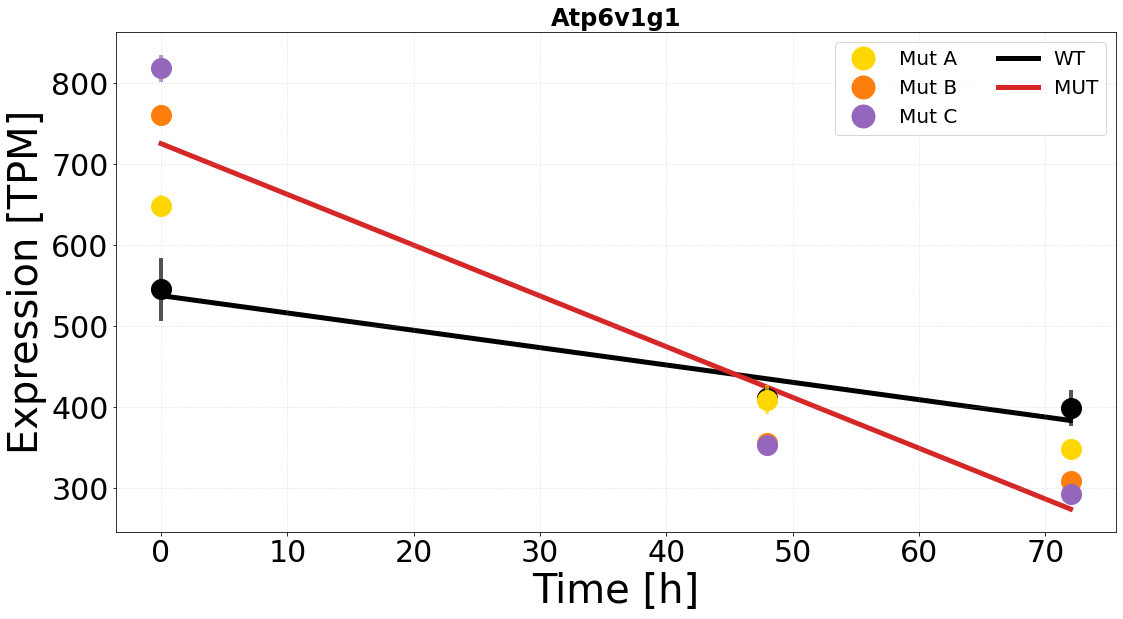

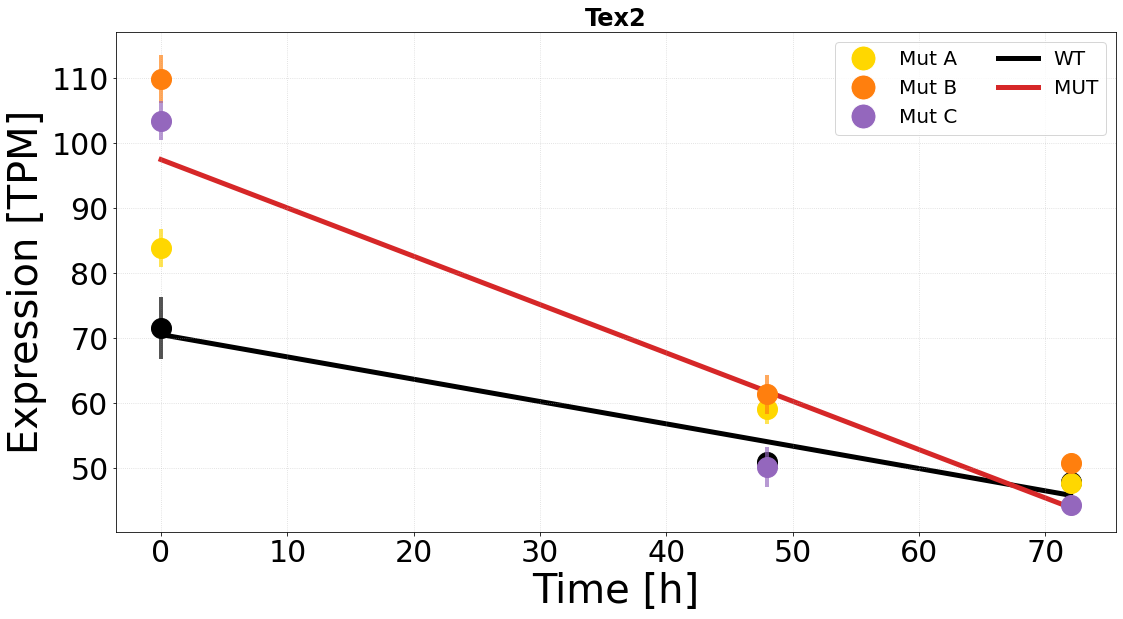

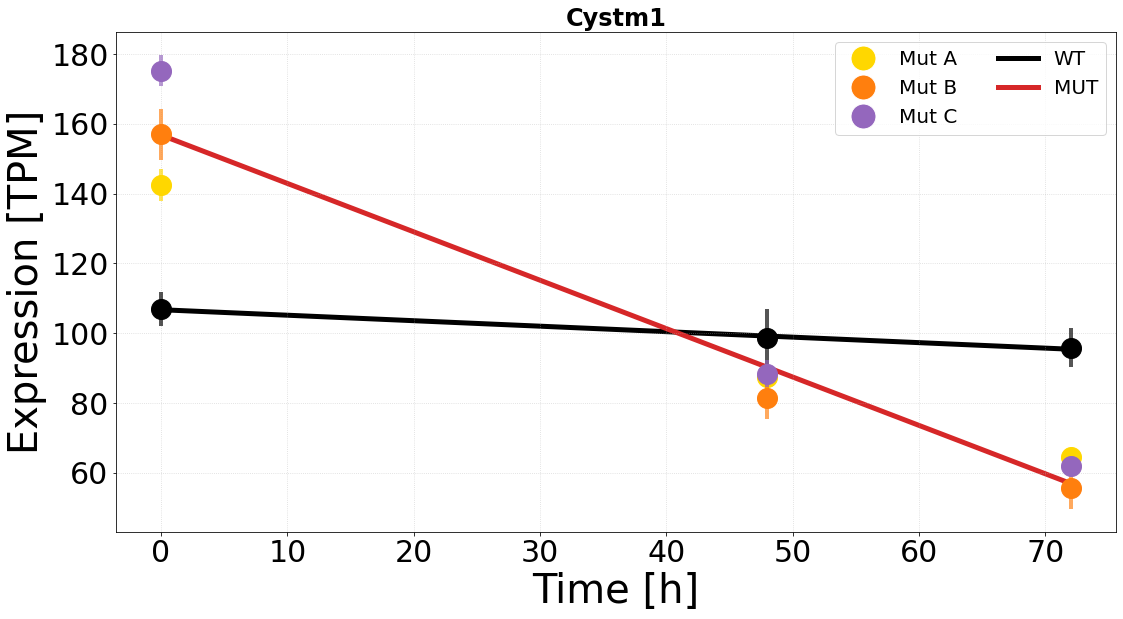

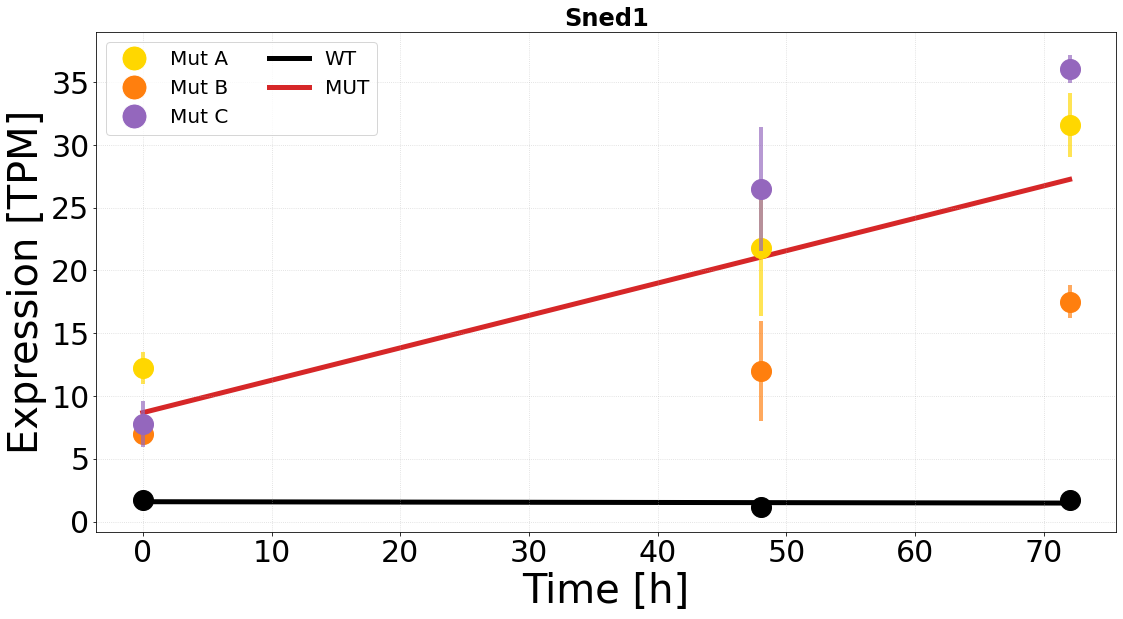

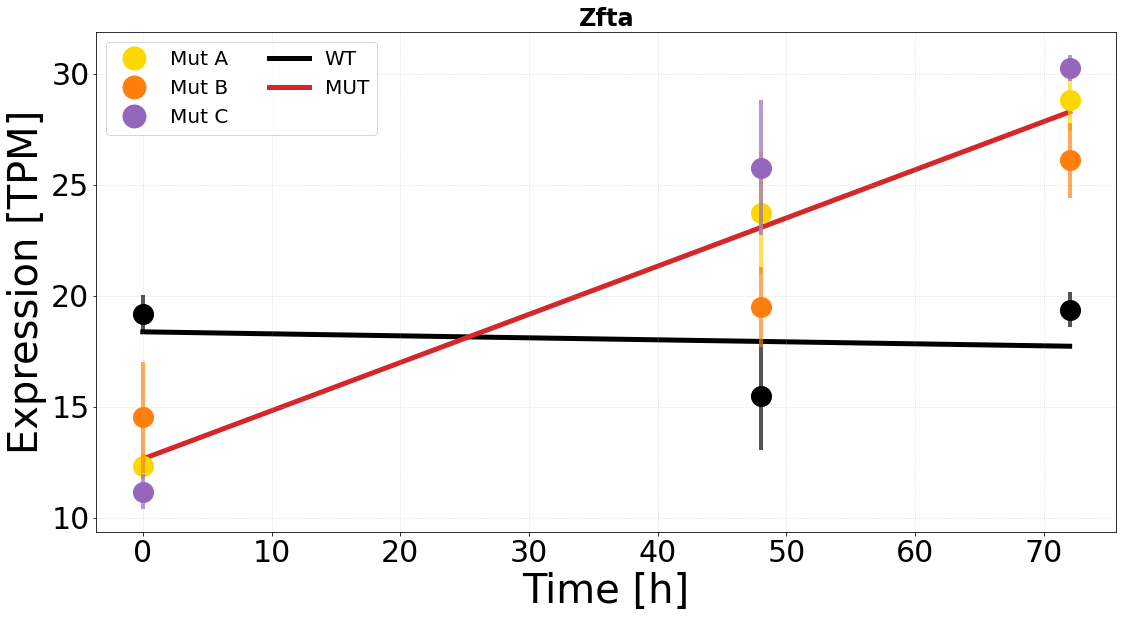

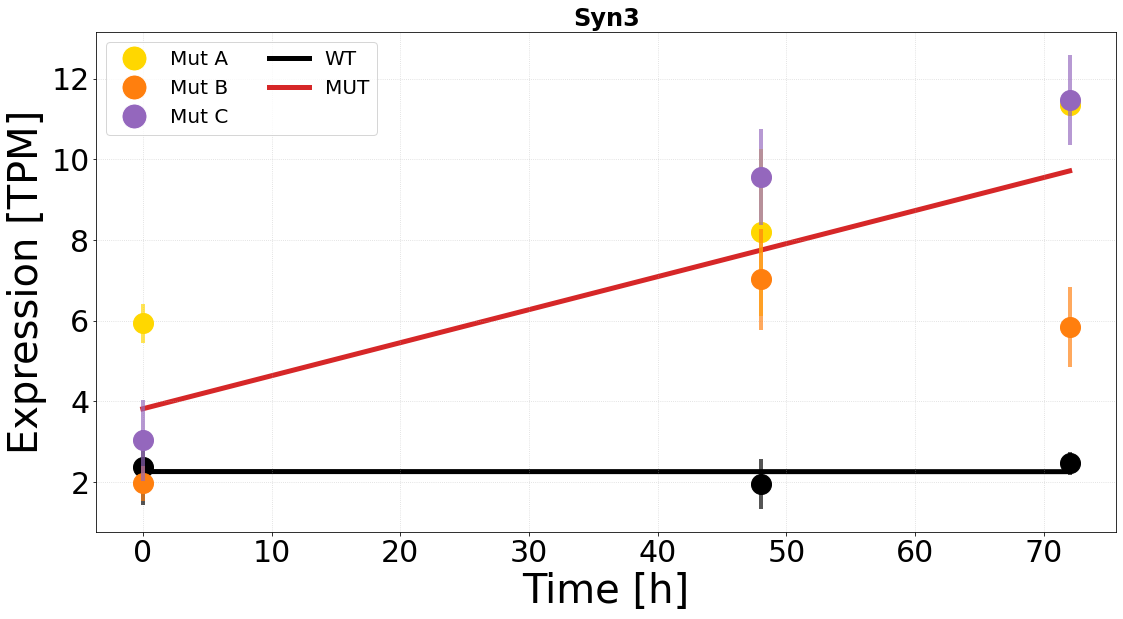

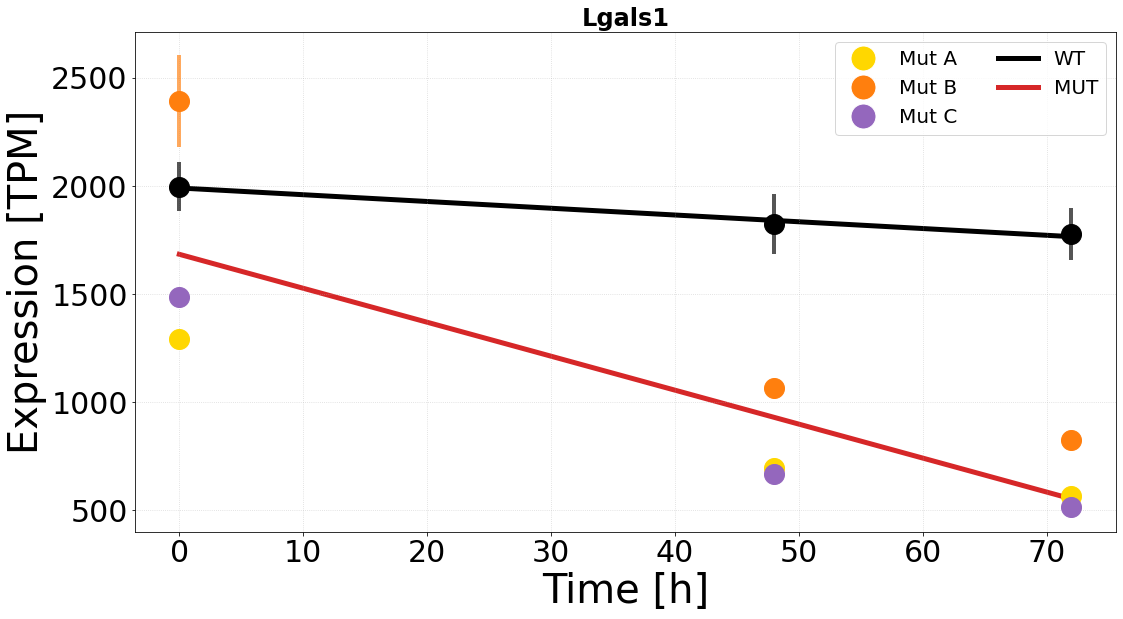

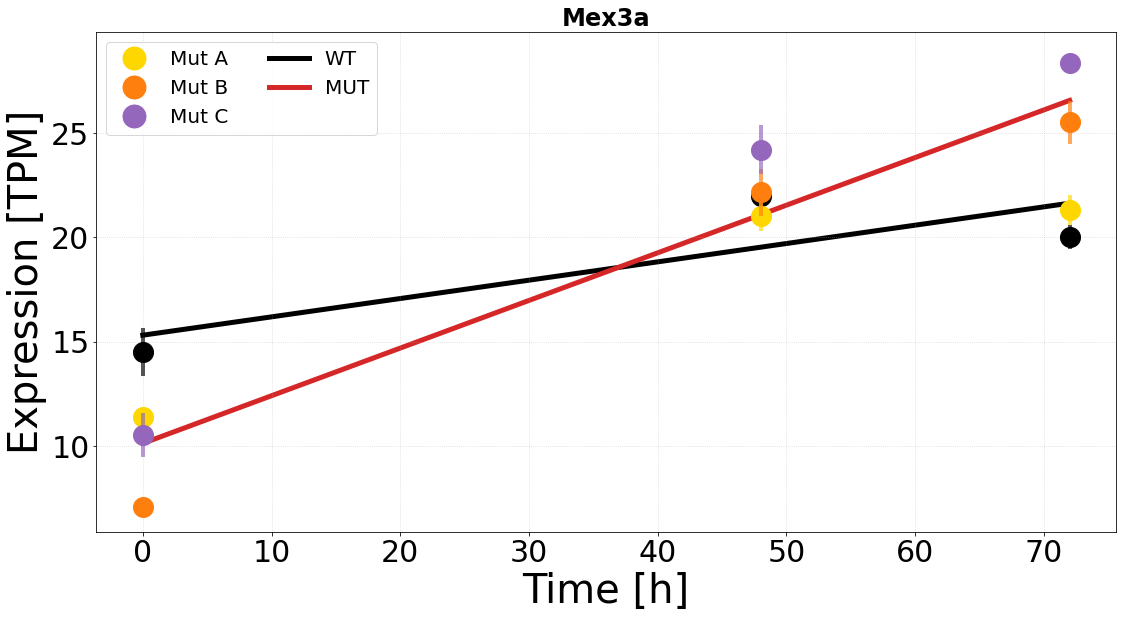

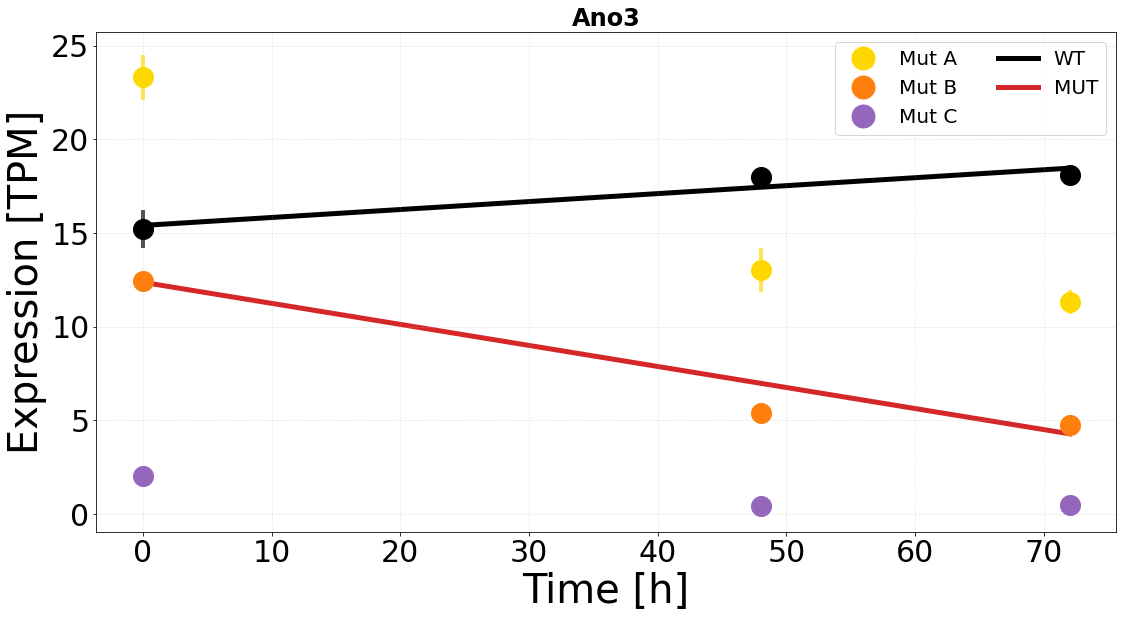

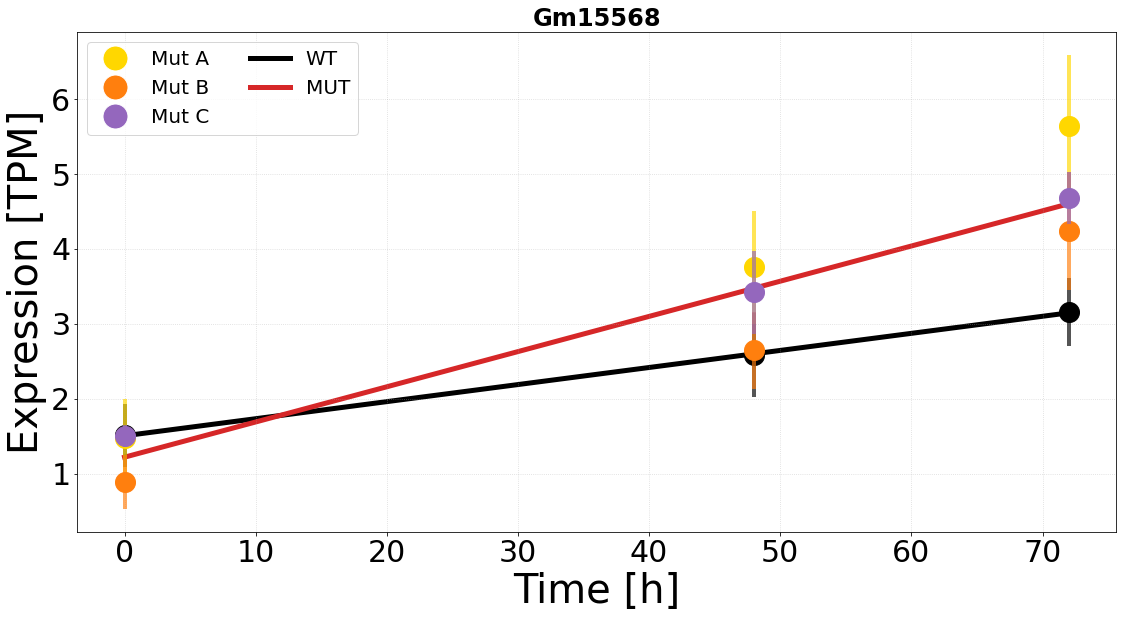

In [22]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_five:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name, fontweight='bold')
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 4.3. generate heatmap on z-score

In [23]:
df = pandas.DataFrame(fitted_change_dict)
tdf = df.transpose()
tdf.columns = simple_expression.columns
tdf.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
Naglu,96.020126,86.069397,81.094033,111.170253,61.076006,36.028882
Cp,18.699444,25.721458,29.232466,1.302006,48.713419,72.419125
Id3,266.289748,230.622965,212.789573,205.797531,406.756989,507.236719
Ctsd,2426.722866,1925.974453,1675.600246,2157.788035,1401.785183,1023.783758
Piezo1,101.665097,87.988178,81.149719,119.887351,66.717086,40.131953


In [24]:
rounded_df = numpy.round(tdf, 0) + 1
rounded_df.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
Naglu,97.0,87.0,82.0,112.0,62.0,37.0
Cp,20.0,27.0,30.0,2.0,50.0,73.0
Id3,267.0,232.0,214.0,207.0,408.0,508.0
Ctsd,2428.0,1927.0,1677.0,2159.0,1403.0,1025.0
Piezo1,103.0,89.0,82.0,121.0,68.0,41.0


In [25]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in rounded_df.index:
    average_expression = numpy.mean(numpy.log10(rounded_df.loc[gene_name, :]))
    fc_wt = (rounded_df.loc[gene_name, 'WT_72h']) / (rounded_df.loc[gene_name, 'WT_0h'])
    fc_mut = (rounded_df.loc[gene_name, 'MUT_72h']) / (rounded_df.loc[gene_name, 'MUT_0h'])
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    
    volcanox.append(delta); volcanoy.append(average_expression)

In [26]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

,WT_0h,WT_48h,WT_72h,MUT_0h,MUT_48h,MUT_72h
Naglu,0.720718,0.308879,0.102960,1.338477,-0.720718,-1.750315
Cp,-0.605038,-0.295141,-0.162327,-1.401918,0.723095,1.741330
Id3,-0.345458,-0.655484,-0.814925,-0.876931,0.903504,1.789293
Ctsd,1.410017,0.336705,-0.198881,0.833728,-0.785882,-1.595687
Piezo1,0.748705,0.197028,-0.078811,1.458004,-0.630488,-1.694437


In [27]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

,MUT_0h,MUT_48h,MUT_72h,WT_0h,WT_48h,WT_72h
Naglu,1.338477,-0.720718,-1.750315,0.720718,0.308879,0.102960
Cp,-1.401918,0.723095,1.741330,-0.605038,-0.295141,-0.162327
Id3,-0.876931,0.903504,1.789293,-0.345458,-0.655484,-0.814925
Ctsd,0.833728,-0.785882,-1.595687,1.410017,0.336705,-0.198881
Piezo1,1.458004,-0.630488,-1.694437,0.748705,0.197028,-0.078811


In [28]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

2.087049363420463
-2.088931871468374


In [29]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

In [ ]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
# just a different visualization of the same data
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap='RdBu_r', col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

## 4.4. pseudo volcano plot

In [ ]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(7/50), volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(7/12), volcanoy[i]+(3.5/25), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-5, 5])
matplotlib.pyplot.ylim([0, 3.5])
matplotlib.pyplot.tight_layout()

# 5. Mitf direct targets analysis

## 5.1. read Dorothea database

In [ ]:
dorothea = pandas.read_csv(dorothea_file, sep='\t', index_col=0)
print(dorothea.shape)
dorothea.head()

In [ ]:
# define gene names for annotation
annotation_gene_names = set(annotation['ext_gene'].to_list())
print('annotation genes: {}'.format(len(annotation_gene_names)))

a = set(dorothea['tf'].to_list())
b = set(dorothea['target'].to_list())
dorothea_genes = a.union(b)
print('dorothea genes: {}'.format(len(dorothea_genes)))


universe = list(annotation_gene_names & dorothea_genes)
print('common universe genes: {}'.format(len(universe)))

## 5.2. define the set of Mitf direct targets

In [ ]:
direct_targets = dorothea[dorothea['tf'] == 'Mitf']
print(direct_targets.shape)
direct_targets.head()

In [ ]:
direct_targets_names = direct_targets['target'].to_list()
print(len(direct_targets_names))

## 5.3. define the number of responding genes among Mitf direct target genes

In [ ]:
print(direct_targets_names, len(direct_targets_names))
response_genes = gene_names.to_list()
print(response_genes, len(response_genes))

In [ ]:
successes = list(set(direct_targets_names) & set(response_genes))
print(successes)

In [ ]:
## 5.4. plot the behaviour of the Mitf direct target genes

In [ ]:
list_six = []
for gene_name in direct_targets_names:
    ensembl = annotation[annotation['ext_gene'] == gene_name].index.to_list()[0]
    list_six.append(ensembl)
print(len(list_six))

In [ ]:
expression_labels = expression.columns
wt_labels = [label for label in simple_expression.columns if 'WT' in label]
mut_labels = [label for label in simple_expression.columns if 'MUT' in label]
fitted_change_dict = {}

for ensembl in list_six:
    gene_name = annotation.loc[ensembl]['ext_gene']
    ensembl_trajectory = []; ensembl_times = []
    fitted_change_dict[gene_name] = []
    
    for mouse in mice:
        plotting_means = []
        plotting_stds = []
        
        for time in times:
            working_labels = [label for label in expression_labels if mouse in label and time in label]
            values = expression.loc[ensembl, working_labels]
            plotting_means.append(numpy.mean(values))
            plotting_stds.append(numpy.std(values))
            
            for value in values.to_list():
                ensembl_trajectory.append(value)
                ensembl_times.append(int(time.split('h')[0]))
            
        # plot data
        if mouse == 'a3922':
            the_color = 'black'
        elif mouse == 'a4774':
            the_color = 'gold'
        elif mouse == 'a4775':
            the_color = 'tab:orange'
        elif mouse == 'a4776':
            the_color = 'tab:purple'
        else:
            print('error')
        matplotlib.pyplot.errorbar(numerical_times, plotting_means, yerr=plotting_stds, color=the_color, lw=0, elinewidth=4, alpha=2/3)
        matplotlib.pyplot.plot(numerical_times, plotting_means, 'o', color=the_color, ms=20)
            
    # fit and visualize trend
    x = ensembl_times[:9]
    y = ensembl_trajectory[:9]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='black', lw=5, zorder=0)
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
    
    x = ensembl_times[9:]
    y = ensembl_trajectory[9:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    newx = numpy.arange(0, 72+1, 1)
    newy = slope*newx + intercept
    matplotlib.pyplot.plot(newx, newy, '-', color='tab:red', lw=5, zorder=0)
    
    # store info for z-score heatmap
    d = slope*numpy.array(numerical_times) + intercept
    for element in d:
        fitted_change_dict[gene_name].append(element)
        
    # define legend elements
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='gold', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:orange', markersize=25),
        matplotlib.lines.Line2D([0], [0], color='white', marker='o', markeredgecolor='white', markerfacecolor='tab:purple', markersize=25),
        
        matplotlib.lines.Line2D([0], [0], color='black', ls='-', lw=5),
        matplotlib.lines.Line2D([0], [0], color='tab:red', ls='-', lw=5)      
]
    matplotlib.pyplot.legend(legend_elements, ['Mut A', 'Mut B', 'Mut C', 'WT', 'MUT'], ncol=2)
    
    # close figure
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.title(gene_name)
    matplotlib.pyplot.xlabel('Time [h]')
    matplotlib.pyplot.ylabel('Expression [TPM]')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## 5.5. build a heatmap of direct targets

In [ ]:
df = simple_expression.loc[list_six, :]

new_index = {}
for ensembl in list_six:
    gene_name = annotation.loc[ensembl]['ext_gene']
    new_index[ensembl] = gene_name
df.rename(index=new_index, inplace=True)

print(df.shape)
df.head()

In [ ]:
rounded_df = numpy.round(df, 0) + 1
rounded_df.head()

In [ ]:
# retrieve x and y for volcano plot
volcanox = []; volcanoy = []
for gene_name in rounded_df.index:
    average_expression = numpy.mean(numpy.log10(rounded_df.loc[gene_name, :]))
    fc_wt = (rounded_df.loc[gene_name, 'WT_72h']) / (rounded_df.loc[gene_name, 'WT_0h'])
    fc_mut = (rounded_df.loc[gene_name, 'MUT_72h']) / (rounded_df.loc[gene_name, 'MUT_0h'])
    delta = numpy.log2(fc_mut) - numpy.log2(fc_wt)
    
    volcanox.append(delta); volcanoy.append(average_expression)

In [ ]:
zscore_df = scipy.stats.zscore(rounded_df, axis=1)
zscore_df.head()

In [ ]:
zscore_df.fillna(0, inplace=True)
zscore_df.head()

In [ ]:
zscore_df = zscore_df[['MUT_0h', 'MUT_48h', 'MUT_72h','WT_0h', 'WT_48h', 'WT_72h']]
zscore_df.head()

In [ ]:
print(numpy.max(zscore_df.max()))
print(numpy.min(zscore_df.min()))

top = 2.5; bottom = -2.5
top_white = 5/6; bottom_white = -5/6

In [ ]:
# edited from https://stackoverflow.com/questions/59270751/how-to-make-a-diverging-color-bar-with-white-space-between-two-values-matplotlib
p = [bottom, bottom_white, top_white, top]
f = lambda x: numpy.interp(x, p, [0, 0.5, 0.5, 1])
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', list(zip(numpy.linspace(0,1), matplotlib.pyplot.cm.bwr(f(numpy.linspace(min(p), max(p)))))))

In [ ]:
linkage_method = 'ward'
distance_metric = 'euclidean'
seaborn.set(font_scale=0.9)

seaborn.clustermap(zscore_df, cmap=new_cmap, col_cluster=False, vmin=bottom, vmax=top, method=linkage_method, metric=distance_metric, yticklabels=1, xticklabels = ['MUT 0h', 'MUT 48h', 'MUT 72h', 'WT 0h', 'WT 48h', 'WT 72h'], cbar_kws={'label':'Expression (z-score)'})

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
seaborn.reset_orig()
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 5.6. pseudo volcano plot

In [ ]:
gene_names = rounded_df.index

for i in range(len(volcanox)):
    
    if -1 <= volcanox[i] <= 1:
        the_color = 'gray'
        matplotlib.pyplot.text(volcanox[i], volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] > 1:
        the_color = 'tab:red'
        matplotlib.pyplot.text(volcanox[i]+(11/60), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    elif volcanox[i] < -1:
        the_color = 'tab:blue'
        matplotlib.pyplot.text(volcanox[i]-(11/12), volcanoy[i]+(11.5/60), gene_names[i], color=the_color)
    else:
        print(volcanox[i])
        print('error')
        
    # finally plotting the dot
    matplotlib.pyplot.scatter(volcanox[i], volcanoy[i], s=1000, c=the_color, alpha=2/3, edgecolor='none')
    
    # printing for interpretation
    if the_color == 'tab:blue':
        printing_color = 'blue'
    elif the_color == 'tab:red':
        printing_color = 'red'
    else:
        printing_color = 'grey'
    message = '\t'.join([gene_names[i], '{:.3f}'.format(volcanox[i]), '{:.3f}'.format(volcanoy[i]), the_color])
    print(termcolor.colored(message, printing_color))

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('Differential response\n[log$_2$FC$^{MUT}$(T72/T0) -  log$_2$FC$^{WT}$(T72/T0)]')
matplotlib.pyplot.ylabel('Average expression\n[log$_{10}$ TPM]')
matplotlib.pyplot.axvline(1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.axvline(-1, color='gray', ls='--', lw=3, zorder=0)
matplotlib.pyplot.xlim([-2.5, 2.5])
matplotlib.pyplot.ylim([0, 4.5])
matplotlib.pyplot.tight_layout()